In [29]:
from scipy.io import loadmat
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from pylab import cm
from matplotlib.colors import ListedColormap
import json
from sklearn import preprocessing


from rankcorr import rFree, rW, rFree_sym
from scipy.stats import spearmanr
from scipy.stats import norm

from smooth import smoothen
%matplotlib inline

In [2]:
filelist = ["calcium_data/140708B_140811a_result", 
            "calcium_data/140909C_141112a_result", 
            "calcium_data/141006C_141121a_result",
            "calcium_data/150109A_150302a_result", 
            "calcium_data/151122A_160202a_result", 
            "calcium_data/151122B_160207a_result", 
            "calcium_data/160209A_160430a_result", 
            "calcium_data/160209B_160428a_result"]

In [117]:
def SVM_presence_single(filename, amp, svm_kernel='linear', cv=5, scoring='accuracy'):
    '''
    Trains an SVM on the Ca2+ data of single dendrites to detect stimulus presence.
    
    filename: string, name of experiment file
    amp: float, stimulus strength, must exist
    svm_kernel: string, specifies svm kernel to use for training
    cv: int, number of folds for cv
    
    returns: n_dendrites x cv ndarray. Each row holds the accuracy values for each fold for one dendrite.
    '''
    f = h5py.File(filename+".hdf5", "r")
    data = f['data']
    meta = f['meta']
    g = h5py.File(filename[:-6]+"roi.hdf5", "r")
    motion_mask = (g['inFrameDend'][:].astype(bool)).reshape(g['inFrameDend'].shape[0])
    #load data

    stims = np.unique(meta[:,1])[1:]        #exclude zero-stim-trials
    assert(amp in list(stims)), "this stimAmp was not used in chosen experiment. Cose one from {}.".format(stims)
    #load stimAmps and check whether the chosen amp matches one of them

    clf = svm.SVC(kernel=svm_kernel)
    #create classifier
    
    #n_dendrites = data.shape[1]
    n_dendrites = np.sum(motion_mask)
    #number of dendrites, loop over these
    
    sc = np.zeros((n_dendrites, cv))
    #will later hold the cv-scores
    for site in range(n_dendrites):
        baseline = np.mean(data[:,motion_mask,:58], axis=2).reshape(data.shape[0], data[:,motion_mask,:].shape[1], 1)
        #baselibe for every trial is the mean over the first second - 58 frames
        
        mn_dnd_chng = np.mean(data[:,motion_mask,58:116]-baseline, axis=2)
        #mean dendritic change = second second minus baseline, mean

        present_mask = meta[:,1]==amp
        absent_mask = meta[:,1]==0
        #boolean masks of the trials where stimAmp==amp and stimAmp==0

        trials_mask = np.logical_or(present_mask, absent_mask)
        #boolean mask for all trials where the stimulus is either our chosen one or absent (0)

        y_score = mn_dnd_chng[trials_mask, site]
        #score that we use for classification - only stimulus present - and absent trials at one dendrite

        amp_mask = meta[:,1][trials_mask]==amp
        y_true = (amp_mask-0.5)*2
        #take all trials used for making y_score. Mark the present ones with a '1', absent ones with a '-1'
        
        ###########
        global _blb_
        _blb_.append(y_score)
        ###########
        
        if scoring == 'accuracy':
            scores = cross_val_score(clf, y_score.reshape(y_score.shape[0], 1), y_true.reshape(y_true.shape[0]), cv=cv, scoring=scoring)
            #compute accuracy scores using crossvalidation
        if scoring == 'roc_auc':
            scores = 2*(cross_val_score(clf, y_score.reshape(y_score.shape[0], 1), y_true.reshape(y_true.shape[0]), cv=cv, scoring=scoring)-0.5)

        
        sc[site, :] = scores
        
    return sc

# Ca2+ as a predictor of stimulus presence
### All dendrites

In [148]:
filename = filelist[1]
amp = 1

scs = SVM_presence_single(filename, amp, scoring='accuracy')

In [149]:
presence_masks = []

In [150]:
n_dendrites = h5py.File(filename+'.hdf5', 'r')['data'].shape[1]
g = h5py.File(filename[:-6]+"roi.hdf5", "r")
motion_mask = (g['inFrameDend'][:].astype(bool)).reshape(g['inFrameDend'].shape[0])

means = np.mean(scs, axis=1)
sdvs = np.std(scs, axis=1)

true_site = 0
for site in range(n_dendrites):
    if motion_mask[site]:
        print("For recording site {0}: accuracy: {1: .2f} (+/- {2: .2f})".format(site, means[true_site], sdvs[true_site]*2))
        true_site += 1
    else:
        print("Site {} was discarded".format(site))
#for site, mean in enumerate(means):
#    print("For recording site {0}: accuracy: {1: .2f} (+/- {2: .2f})".format(site, mean, sdvs[site]*2))

Site 0 was discarded
Site 1 was discarded
Site 2 was discarded
Site 3 was discarded
For recording site 4: accuracy:  0.48 (+/-  0.15)
For recording site 5: accuracy:  0.48 (+/-  0.09)
For recording site 6: accuracy:  0.46 (+/-  0.22)
For recording site 7: accuracy:  0.57 (+/-  0.08)
For recording site 8: accuracy:  0.52 (+/-  0.05)
For recording site 9: accuracy:  0.48 (+/-  0.05)
For recording site 10: accuracy:  0.49 (+/-  0.19)
For recording site 11: accuracy:  0.53 (+/-  0.21)
For recording site 12: accuracy:  0.44 (+/-  0.10)
For recording site 13: accuracy:  0.50 (+/-  0.07)
For recording site 14: accuracy:  0.42 (+/-  0.05)
For recording site 15: accuracy:  0.49 (+/-  0.08)
For recording site 16: accuracy:  0.56 (+/-  0.12)
For recording site 17: accuracy:  0.52 (+/-  0.21)
For recording site 18: accuracy:  0.56 (+/-  0.22)
For recording site 19: accuracy:  0.54 (+/-  0.16)
For recording site 20: accuracy:  0.50 (+/-  0.10)
For recording site 21: accuracy:  0.54 (+/-  0.13)
For 

In [151]:
n_mask = 0
out_mask_presence = np.ones(n_dendrites).astype(bool)
n_out = 10
inds = np.argsort(means)[::-1]
ds = []

print("{} recordings sites best for classification:".format(n_out))
for i in range(n_out):
    c = -1
    for j in range(n_dendrites):
        c += motion_mask[j]
        d = j
        if c == inds[i]:
            break
    if n_mask > 0:
        out_mask_presence[d] = False
        n_mask -= 1
    ds.append(d)
    print("At recording site {0}: accuracy: {1: .2f} (+/- {2: .2f})".format(d, means[inds[i]], sdvs[inds[i]]*2))
presence_masks.append(out_mask_presence)

10 recordings sites best for classification:
At recording site 50: accuracy:  0.64 (+/-  0.23)
At recording site 46: accuracy:  0.59 (+/-  0.33)
At recording site 53: accuracy:  0.59 (+/-  0.15)
At recording site 7: accuracy:  0.57 (+/-  0.08)
At recording site 44: accuracy:  0.57 (+/-  0.19)
At recording site 62: accuracy:  0.57 (+/-  0.13)
At recording site 18: accuracy:  0.56 (+/-  0.22)
At recording site 42: accuracy:  0.56 (+/-  0.14)
At recording site 16: accuracy:  0.56 (+/-  0.12)
At recording site 21: accuracy:  0.54 (+/-  0.13)


In [68]:
n_mask = 0
out_mask_presence = np.ones(n_dendrites).astype(bool)
n_out = 10
inds = np.argsort(means)[::-1]
inds_rev = np.argsort(means)

print("{} recordings sites best for classification:".format(n_out))
for i in range(n_out):
    c = -1
    for j in range(n_dendrites):
        c += motion_mask[j]
        d = j
        if c == inds[i]:
            break
    print("At recording site {0}: accuracy: {1: .2f} (+/- {2: .2f})".format(d, means[inds[i]], sdvs[inds[i]]*2))
    
print('_----------------------------------------_')
for i in range(n_out):
    c = -1
    for j in range(n_dendrites):
        c += motion_mask[::-1][j]
        d = j
        if c == inds_rev[i]:
            break
    print("At recording site {0}: accuracy: {1: .2f} (+/- {2: .2f})".format(d, means[inds_rev[i]], sdvs[inds_rev[i]]*2))

10 recordings sites best for classification:
At recording site 53: accuracy:  0.44 (+/-  0.51)
At recording site 57: accuracy:  0.40 (+/-  0.28)
At recording site 48: accuracy:  0.38 (+/-  0.49)
At recording site 2: accuracy:  0.37 (+/-  0.74)
At recording site 59: accuracy:  0.36 (+/-  0.33)
At recording site 27: accuracy:  0.36 (+/-  0.44)
At recording site 1: accuracy:  0.33 (+/-  0.59)
At recording site 35: accuracy:  0.28 (+/-  0.64)
At recording site 6: accuracy:  0.26 (+/-  0.58)
At recording site 49: accuracy:  0.24 (+/-  0.68)
_----------------------------------------_
At recording site 91: accuracy: -0.42 (+/-  0.46)
At recording site 42: accuracy: -0.33 (+/-  0.74)
At recording site 54: accuracy: -0.33 (+/-  0.49)
At recording site 71: accuracy: -0.31 (+/-  0.26)
At recording site 83: accuracy: -0.30 (+/-  0.57)
At recording site 3: accuracy: -0.30 (+/-  0.64)
At recording site 16: accuracy: -0.29 (+/-  0.33)
At recording site 68: accuracy: -0.27 (+/-  0.56)
At recording sit

In [118]:
filename = filelist[2]
stims = np.unique(h5py.File(filename+'.hdf5', 'r')['meta'][:,1])[1:]

scss = []
for amp in stims:
    scs = SVM_presence_single(filename, amp, cv=10)
    scss.append(np.mean(scs, axis=1))

In [119]:
rankmat = np.zeros((scs.shape[0],stims.shape[0]))
for k, s in enumerate(scss):
    rankmat[:,k] = np.argsort(s)

In [191]:
np.argsort(rankmat[::-1], axis=0)
#rankmat[::-1]

array([[66, 72, 39, 44, 12, 27],
       [ 3, 95,  5, 64, 83, 95],
       [57, 29, 49, 49, 26,  9],
       [36, 41, 55, 68, 19, 71],
       [55, 37, 47, 12, 45, 49],
       [80, 74, 79, 51, 88, 70],
       [35, 32, 46, 87, 54, 69],
       [76, 39, 88, 62, 37, 91],
       [72, 63, 84, 67, 55, 37],
       [23, 61, 52, 82, 44, 44],
       [74,  0, 26, 35, 50, 15],
       [63, 92, 51, 26, 49, 54],
       [24,  6, 35, 25, 30, 21],
       [26, 50, 54,  9, 40, 26],
       [ 7, 14,  4, 43, 53, 18],
       [82, 25, 95, 42, 73, 75],
       [ 0, 45, 17, 19, 85, 96],
       [88,  1, 62, 47, 16, 19],
       [ 5, 23, 10,  4,  3, 62],
       [31, 46, 36, 88, 52, 72],
       [39, 22, 43, 71, 39, 40],
       [ 6,  7, 68, 20,  8, 17],
       [19, 17, 64,  0, 29,  3],
       [77, 86, 80,  8, 51, 14],
       [21, 49, 30, 57, 62, 61],
       [ 4, 62, 85, 30, 64, 74],
       [ 1, 12,  3,  1,  9,  8],
       [12,  4, 12, 11, 28,  5],
       [29, 21,  8, 17, 15, 45],
       [40, 33, 91, 52, 63, 78],
       [ 2

In [195]:
scmat = np.zeros((scs.shape[0],stims.shape[0]))
for k, s in enumerate(scss):
    scmat[:,k] = s

In [309]:
rhomat = np.zeros((6,6))

for k in range(6):
    for l in range(6):
        R = rankmat[:,k][::-1]
        Q = rankmat[:,l][::-1]
        W = np.clip(scmat[:,k][::-1]-0.5, 0, None)

        rho = rFree(R, Q, W)
        rhomat[k,l] = rho 
        
rhomat_sym = np.zeros((6,6))

for k in range(6):
    for l in range(6):
        R = np.argsort(rankmat[:,k][::-1], axis=0)
        Q = np.argsort(rankmat[:,l][::-1], axis=0)
        W_q = np.clip(scmat[:,k][::-1], 0, None)
        W_r = np.clip(scmat[:,l][::-1], 0, None)

        #Q_sig = W_q >= 0.55
        #R_sig = W_r >= 0.55
        Q_sig = W_q >= np.max(W_q)-0.1
        R_sig = W_r >= np.max(W_r)-0.1
        sig = np.logical_or(Q_sig, R_sig)+0
        W = R*Q*sig
        #W = np.clip((sig*(W_r*W_q+.25)), 0, None)
        
        W_n = np.zeros(sig.shape[0])
        p = np.sum(sig)
        for i, s in enumerate(sig):
            if s != 0:
                W_n[i] = p
                p -= 1
            else:
                pass
        rho = rFree_sym(R, Q, R*sig, Q*sig)
        #rho = rW(R,Q)
        #rho = rFree(R,Q,W_n)
        rhomat_sym[k,l] = rho

mns = np.zeros((6,6))
stds = np.zeros((6,6))
for j in range(6):
    for k in range(6):
        t = np.zeros(1000)
        for i in range(1000):
            #W_n = np.zeros(sig.shape[0])
            #p = np.sum(sig)
            #for i, s in enumerate(sig):
            #    if s != 0:
            #        W_n[i] = p
            #        p -= 1
            #    else:
            #        pass
            R = np.argsort(rankmat[:,j][::-1], axis=0)
            Q = np.argsort(rankmat[:,k][::-1], axis=0)
            W_q = np.clip(scmat[:,j][::-1], 0, None)
            W_r = np.clip(scmat[:,k][::-1], 0, None)
            r = np.random.permutation(R)
            q = np.random.permutation(Q)
            rho = rFree_sym(r,q, R*sig, Q*sig)
            #rho = rW(r,q)
            #rho = rFree(r,q,W_n)
            t[i] = rho
        mn = np.mean(t)
        std = np.std(t)
        mns[j,k] = mn
        stds[j,k] = std
        
pvalmat = np.zeros((6,6))
for i in range(6):
    for j in range(6):
        rho = rhomat_sym[i,j]
        z = (rhomat_sym[i,j] - mns[i,j])/stds[i,j]
        pval = norm.cdf(np.absolute(z))
        pvalmat[i,j] = 1-pval

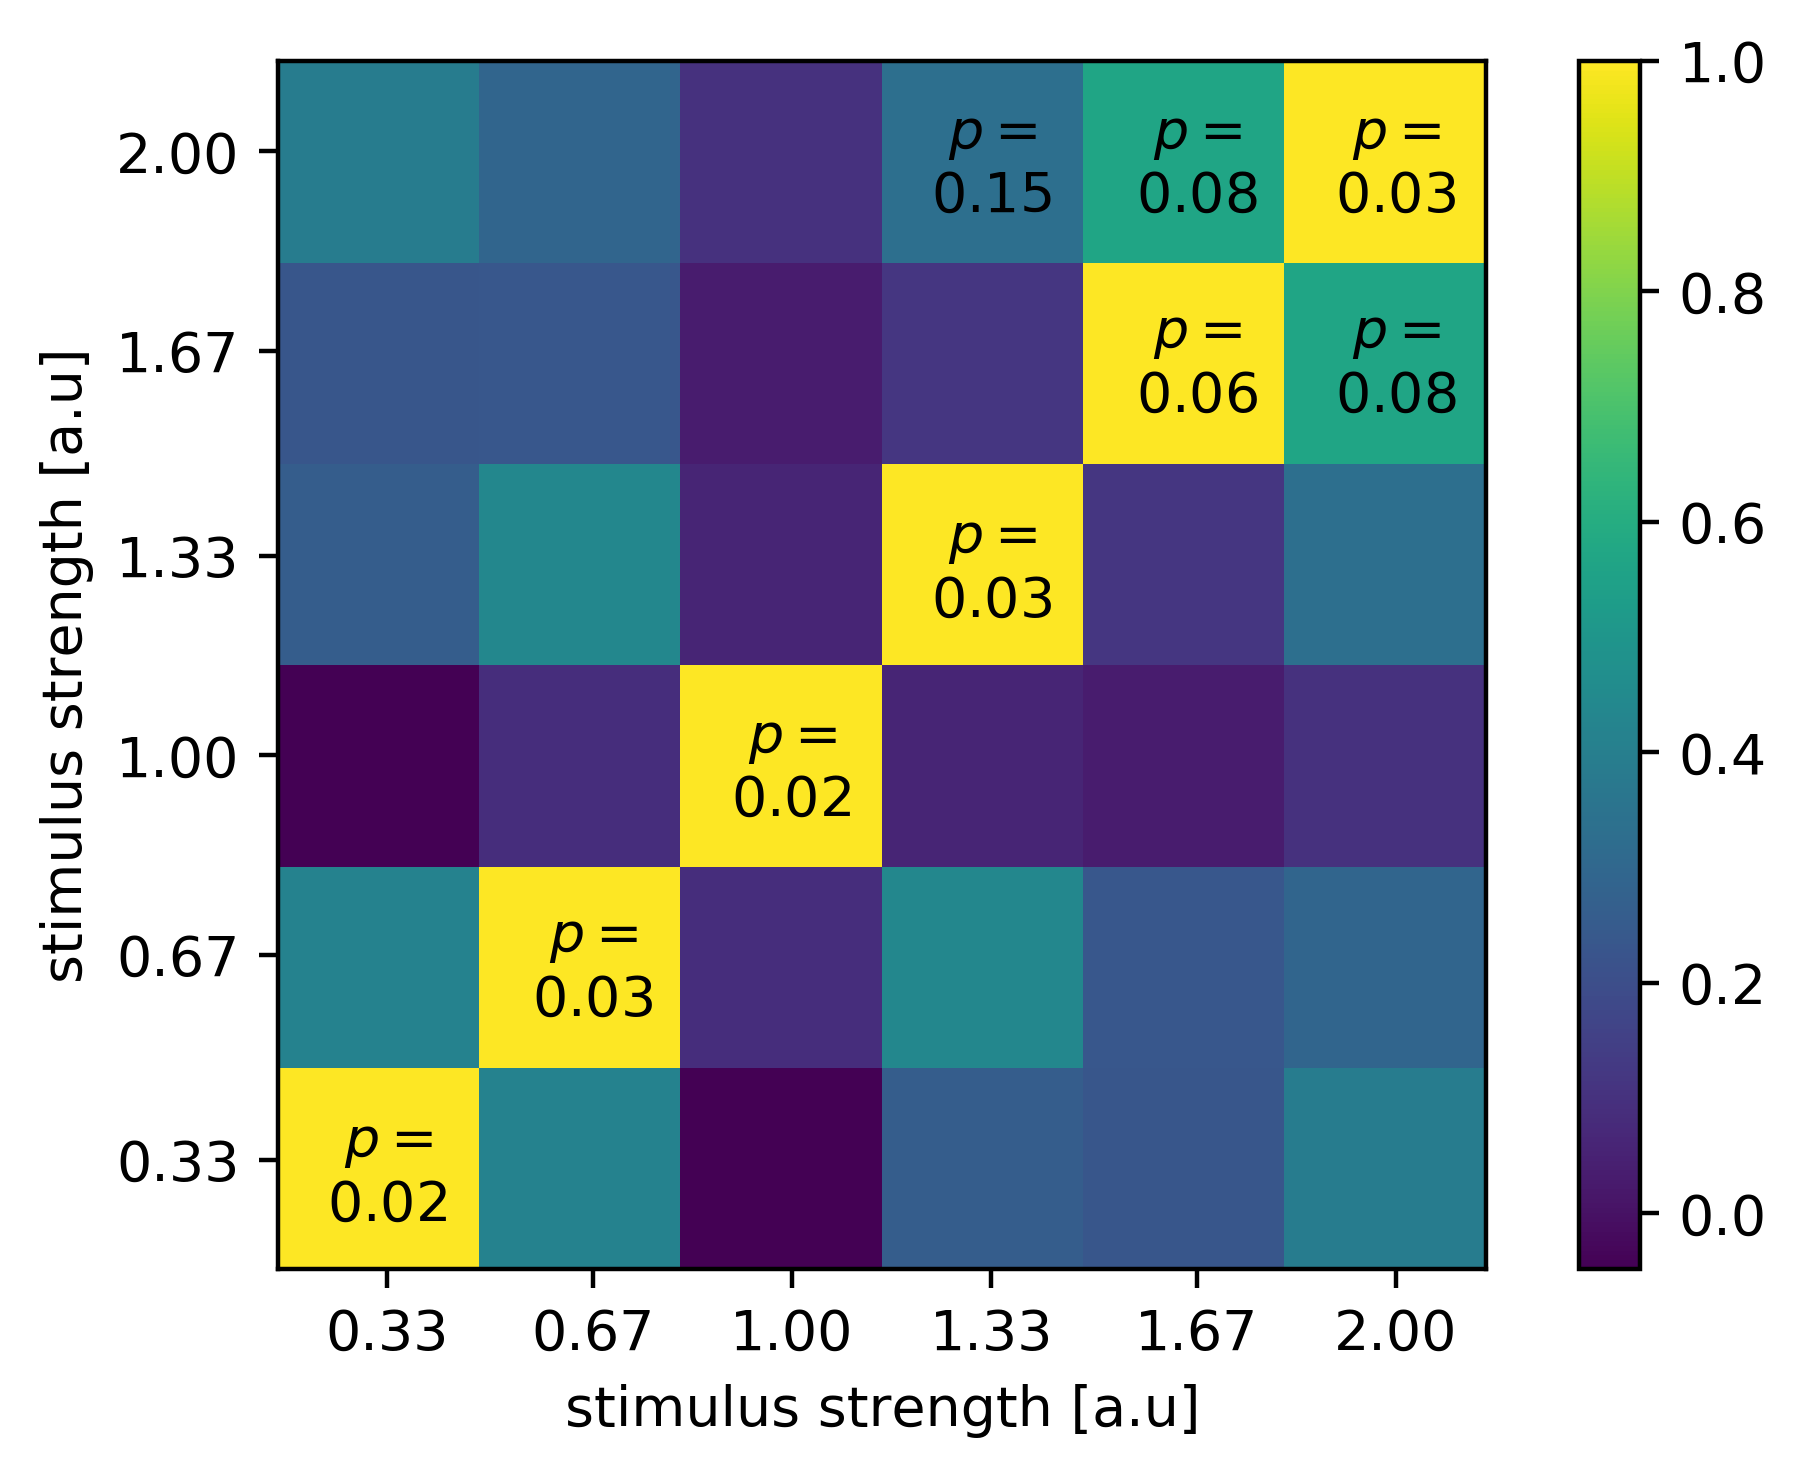

In [327]:
s = np.zeros(stims.shape[0])
for k, amp in enumerate(stims):
    s[k] = '{0: .2f}'.format(amp)

fig = plt.figure(dpi=400)
plt.imshow(rhomat_sym, origin='lower')
plt.colorbar()
for k in range(6):
    for l in range(6):
        if pvalmat[k,l] <=0.15:
            plt.text(s[k]-0.1, s[l]-.1, s=' $p=$\n${0: .2f}$'.format(pvalmat[k,l]))
#plt.figure()
#plt.imshow(rhomat_sym, origin='lower')
#plt.colorbar()
plt.imshow(rhomat_sym, extent=[0.15,2.15,0.15,2.15], origin='lower')
plt.xticks(s.astype(float))
plt.yticks(s.astype(float))

#plt.imshow(pval)

plt.xlabel('stimulus strength [a.u]')
plt.ylabel('stimulus strength [a.u]')

fig.savefig('rank_presence.png')

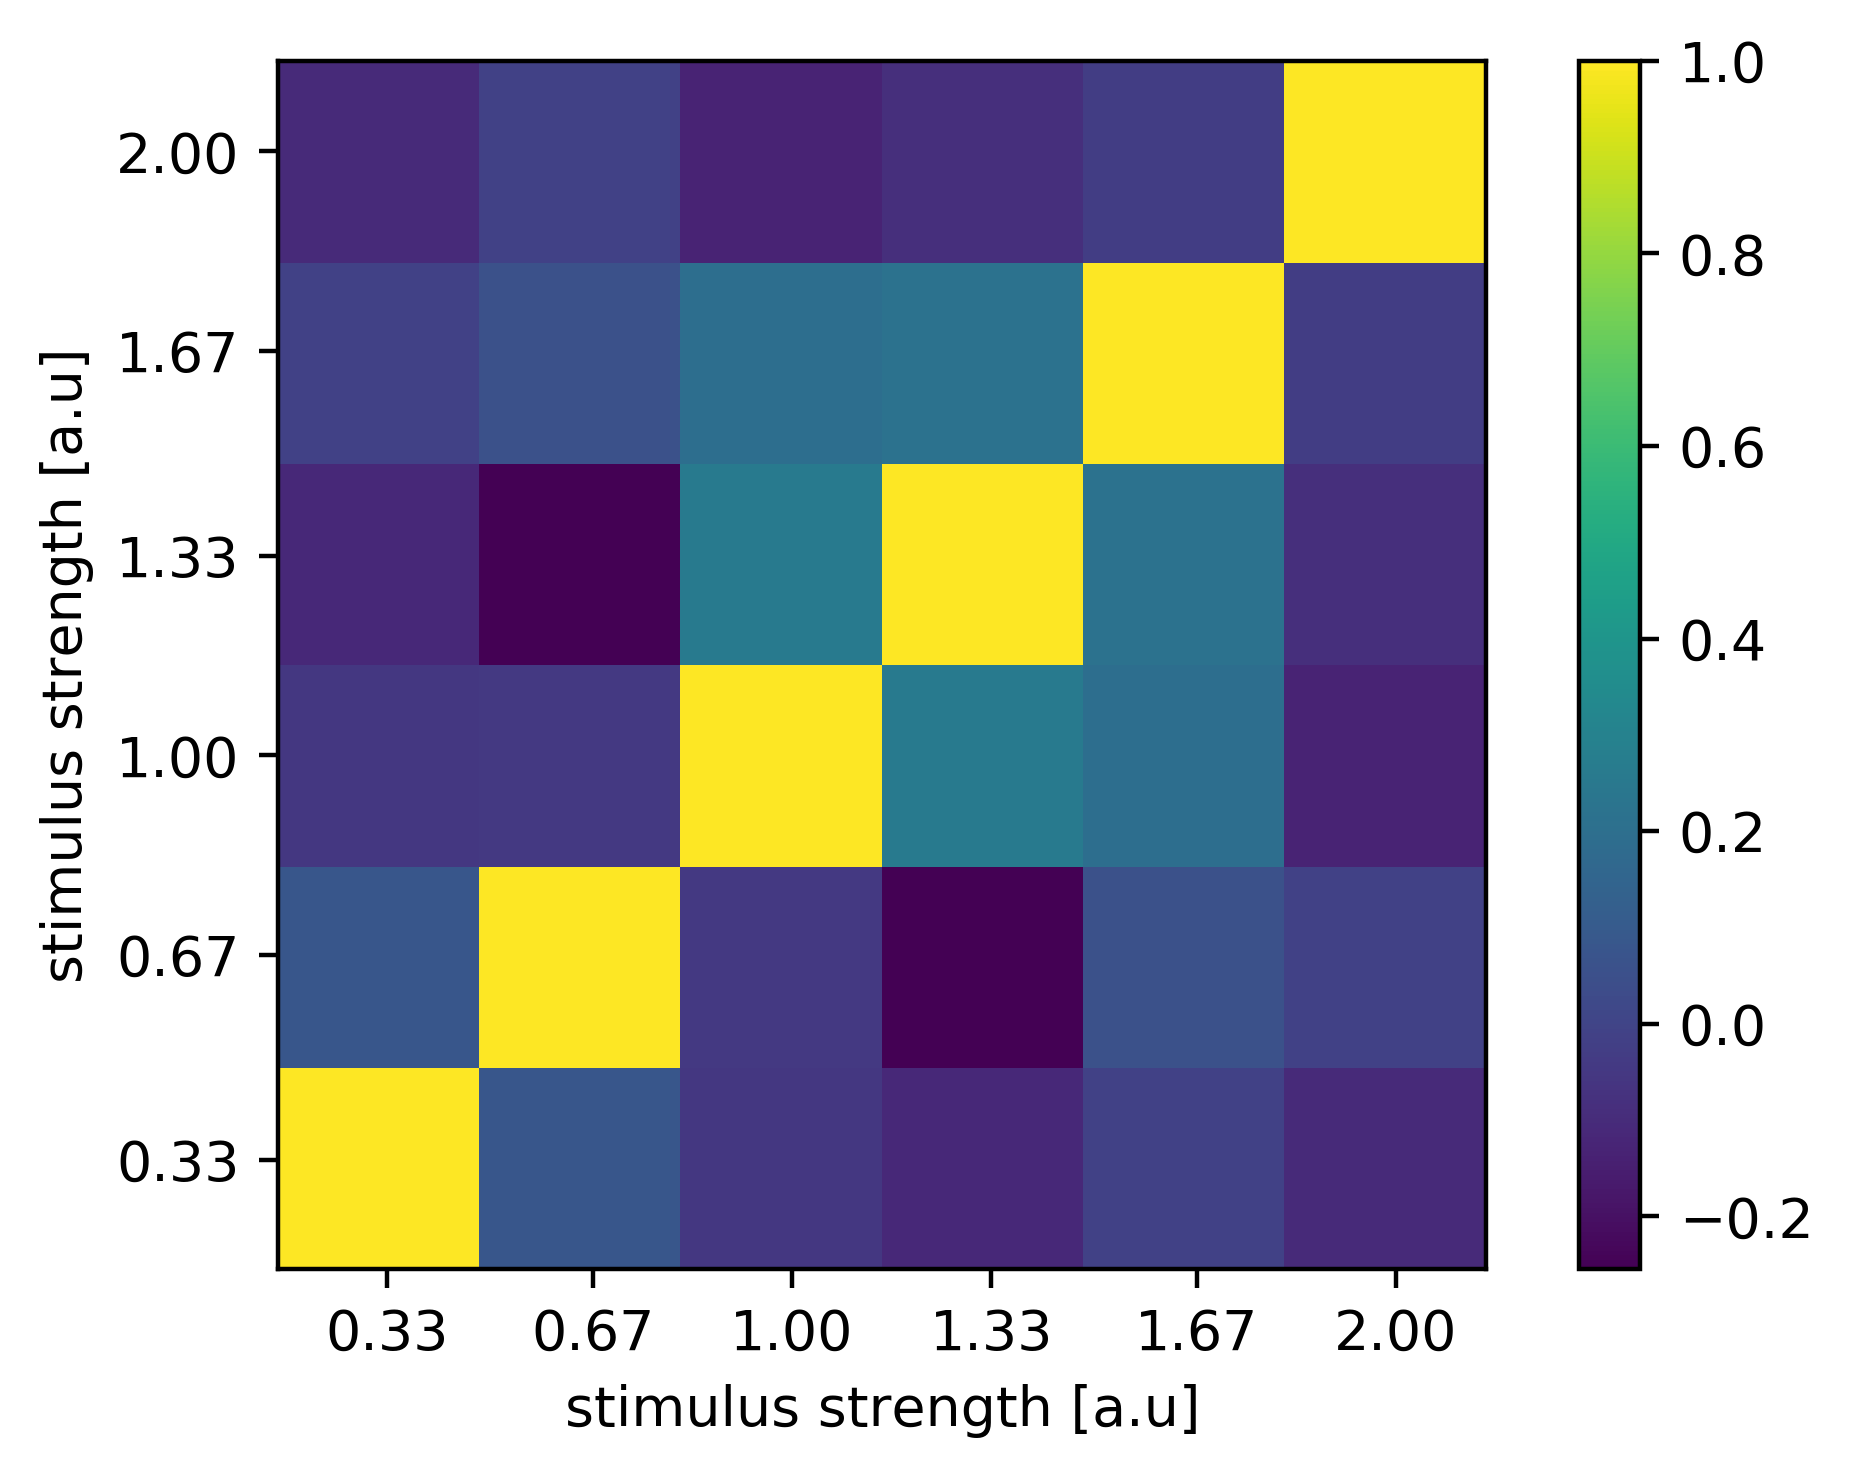

In [314]:
s = np.zeros(stims.shape[0])
for k, amp in enumerate(stims):
    s[k] = '{0: .2f}'.format(amp)

fig = plt.figure(dpi=400) 
    
#rho, pval = spearmanr(rankmat)
rho = np.zeros((6,6))
#plt.imshow(rho, extent=[0.33,2,0.33,2])
plt.imshow(rho, extent=[0.15,2.15,0.15,2.15], origin='lower')
plt.xticks(s.astype(float))
plt.yticks(s.astype(float))

#plt.imshow(pval)
plt.colorbar()

plt.xlabel('stimulus strength [a.u]')
plt.ylabel('stimulus strength [a.u]')

fig.savefig('spearman.png')

In [17]:
a = h5py.File('absDI.hdf5', 'r')
scs = a['DI'][:]

In [18]:
rankmat_c = np.zeros((scs.shape[0], scs.shape[1]))
for i in range(6):
    rankmat_c[:,i] = np.argsort(scs[:,i])

In [19]:
crossmat = np.zeros((6,6))
pvalmat = np.zeros((6,6))
for i in range(6):
    for j in range(6):
        rho, pval = spearmanr(rankmat[-10:,i], rankmat_c[-10:,j])
        crossmat[i,j] = rho
        pvalmat[i,j] = pval

In [130]:
crossmat_ = np.zeros((6,6))
for i in range(6):
    for j in range(6):
        W = scmat[:,i]
        rho = rFree(rankmat[:,i], rankmat_c[:,j], W)
        crossmat_[i,j] = rho
        
crossmat_f = np.zeros((6,6))
for i in range(6):
    for j in range(6):
        inds =  np.argsort(rankmat[:,i])
        W_r = scmat[:,i][inds]
        W_q = scs[:,j][inds]
        rho = rFree_sym(np.argsort(rankmat[:,i]), np.argsort(rankmat_c[:,j]), W_r, W_q)
        crossmat_f[i,j] = rho

t = np.zeros(10000)
for i in range(10000):
    r = np.random.permutation(np.arange(rankmat.shape[0]))
    q = np.random.permutation(np.arange(rankmat.shape[0]))
    rho = rW(r,q)
    t[i] = rho
mn = np.mean(t)
std = np.std(t)

pvalmat = np.zeros((6,6))
for i in range(6):
    for j in range(6):
        rho = crossmat_f[i,j]
        z = (crossmat_f[i,j] - mn)/std
        pval = norm.cdf(np.absolute(z))
        pvalmat[i,j] = 1-pval

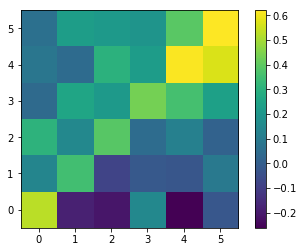

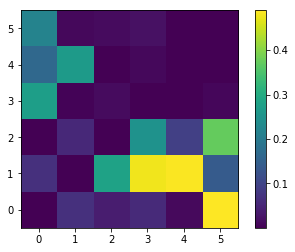

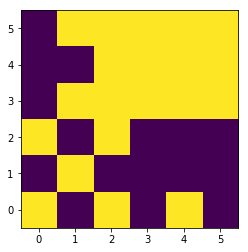

In [131]:
plt.imshow(crossmat_f, origin='lower')
plt.colorbar()
plt.figure()
plt.imshow(pvalmat, origin='lower')
plt.colorbar()
plt.figure()
plt.imshow(pvalmat < 0.05, origin='lower')

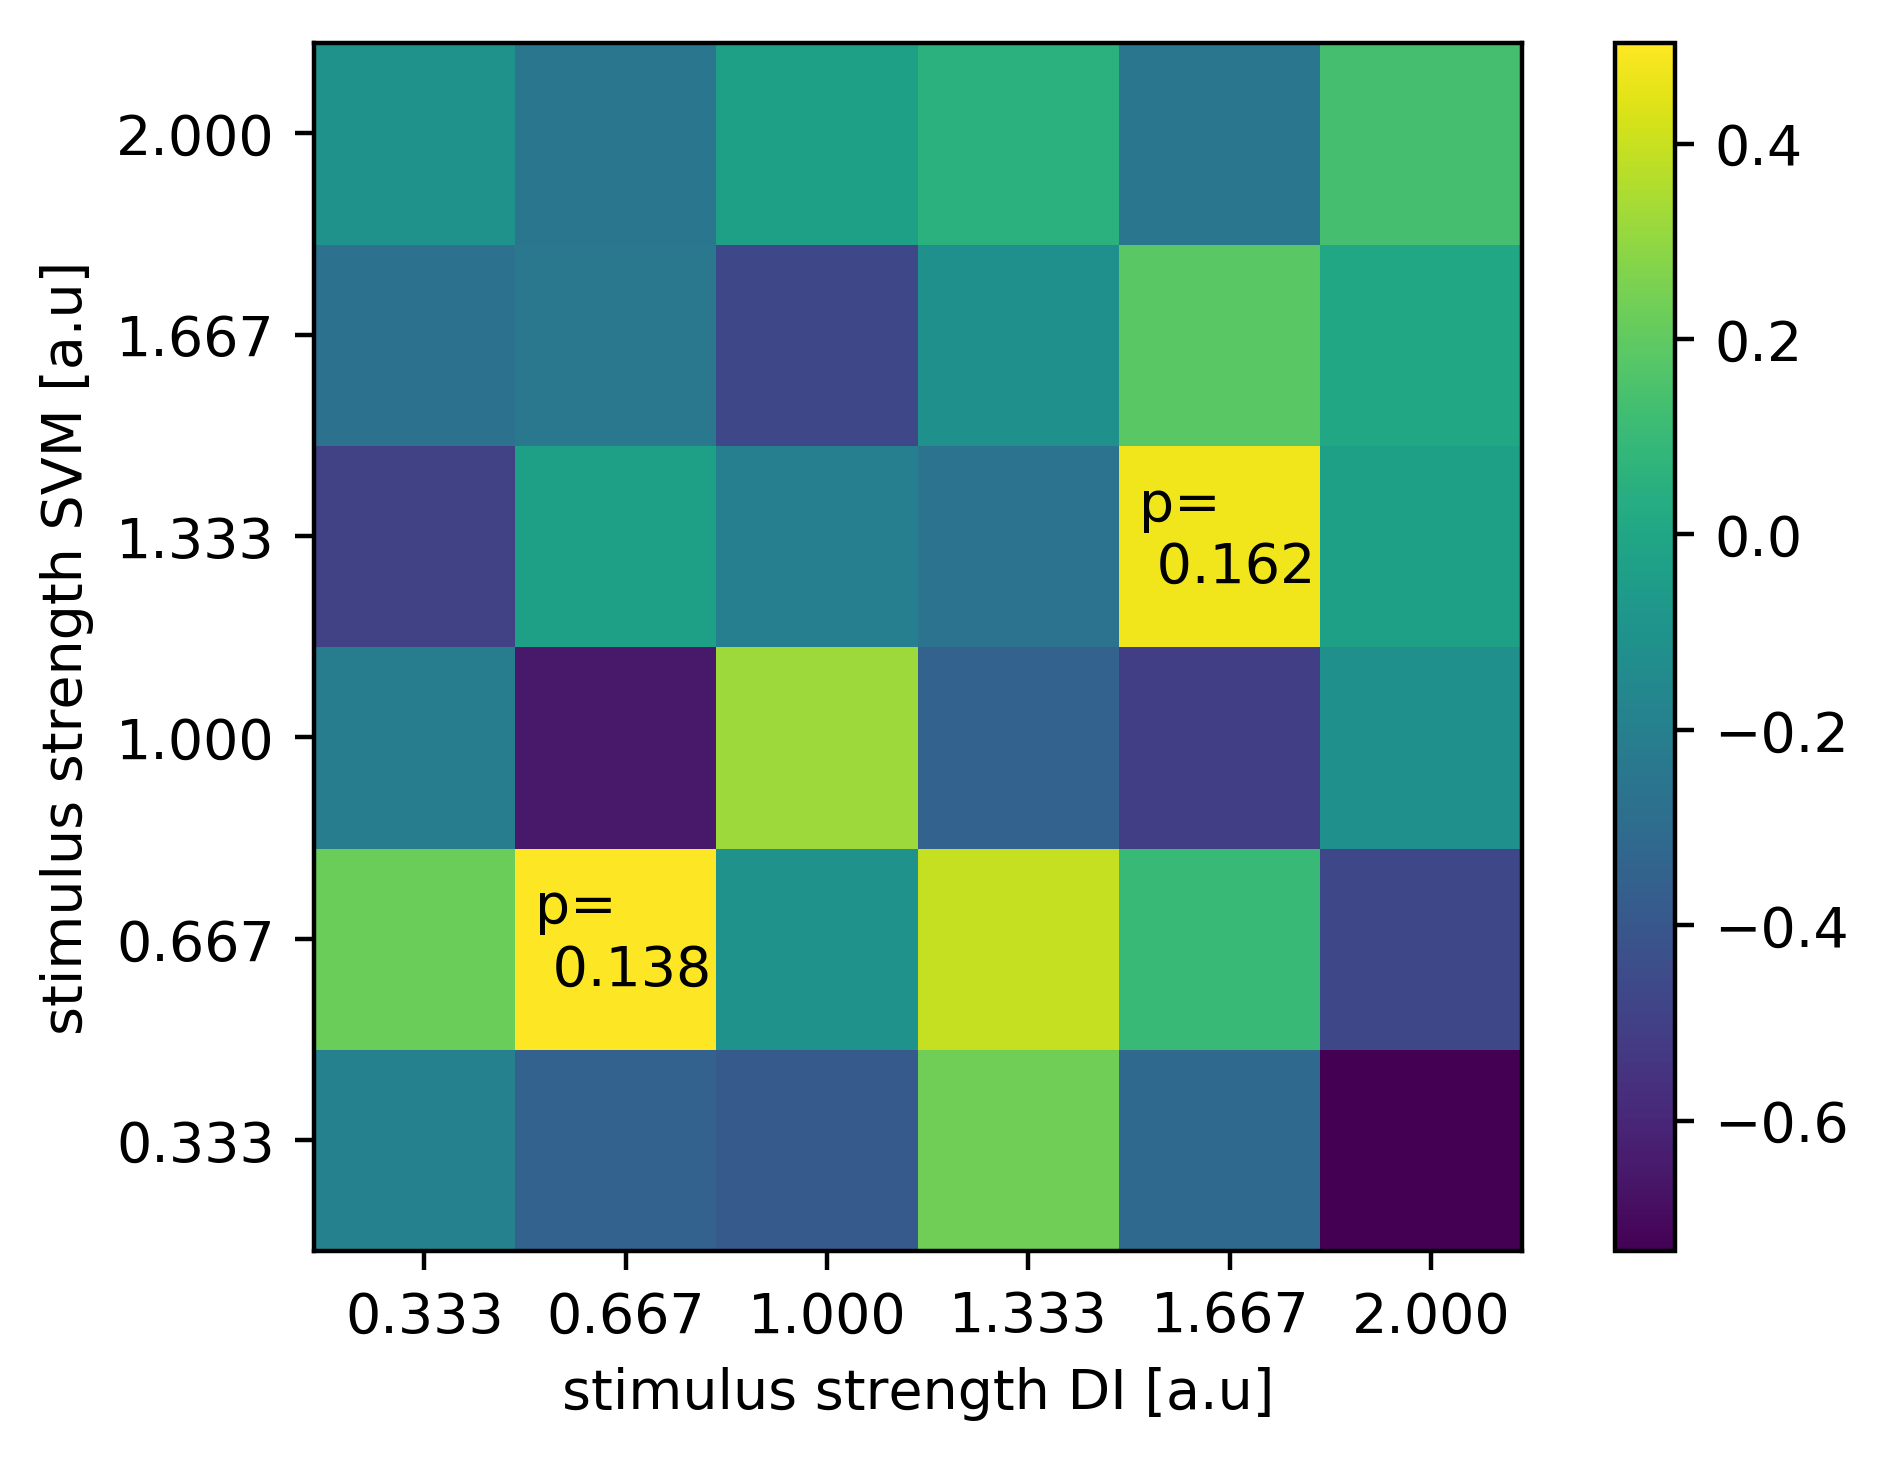

In [20]:
fig = plt.figure(dpi=400)
plt.imshow(crossmat, extent=[0.15,2.15,0.15,2.15], origin='lower')
plt.xticks(stims)
plt.yticks(stims)
for i in range(6):
    for j in range(6):
        if crossmat[i,j] > 0.4:
            plt.text(stims[j]-0.15,stims[i], s='p=\n{0: .3f}'.format(pvalmat[i,j]), va='center')

plt.xlabel('stimulus strength DI [a.u]')
plt.ylabel('stimulus strength SVM [a.u]')
plt.colorbar()

fig.savefig('DI_vs_SVM.png')

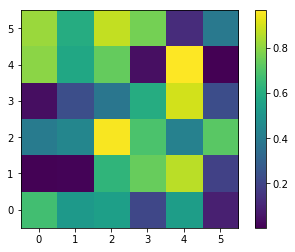

In [64]:
plt.imshow(pvalmat, origin='lower')
plt.colorbar()

In [70]:
print(rankmat[-10:,3])
print(rankmat_c[-10:,3])
print(rW(np.argsort(rankmat[:,3]), np.argsort(rankmat_c[:,3])))
rankmat[:,3]

[ 13.  23.  38.  58.  56.  18.  52.  46.  26.  22.]
[ 46.  94.  22.  11.  64.  56.  26.  52.   0.  58.]
0.562265856795


array([ 68.,  78.,  39.,  53.,  43.,  42.,  48.,  91.,  19.,   6.,  83.,
        71.,  59.,  40.,   9.,  44.,  67.,  33.,  63.,  51.,  89.,  86.,
        80.,  41.,  82.,  20.,  54.,  62.,   3.,   8.,  66.,  87.,   1.,
        93.,   7.,  35.,  31.,  69.,  72.,  24.,  75.,  34.,  37.,  30.,
        29.,   5.,  81.,   2.,  61.,  17.,  74.,  79.,   0.,  14.,  15.,
        50.,  90.,  57.,  45.,  64.,  92.,  10.,  88.,  76.,  73.,  32.,
        25.,  65.,  36.,  94.,  11.,  12.,  85.,  84.,  95.,  60.,  21.,
        16.,  96.,  28.,  70.,  77.,  49.,  55.,   4.,  27.,  47.,  13.,
        23.,  38.,  58.,  56.,  18.,  52.,  46.,  26.,  22.])

In [273]:
scmat = np.zeros((scs.shape[0],stims.shape[0]))
for k, s in enumerate(scss):
    scmat[:,k] = s
ms = scmat < 0.5
scmat[ms] = 0.5

/home/ge0rg/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


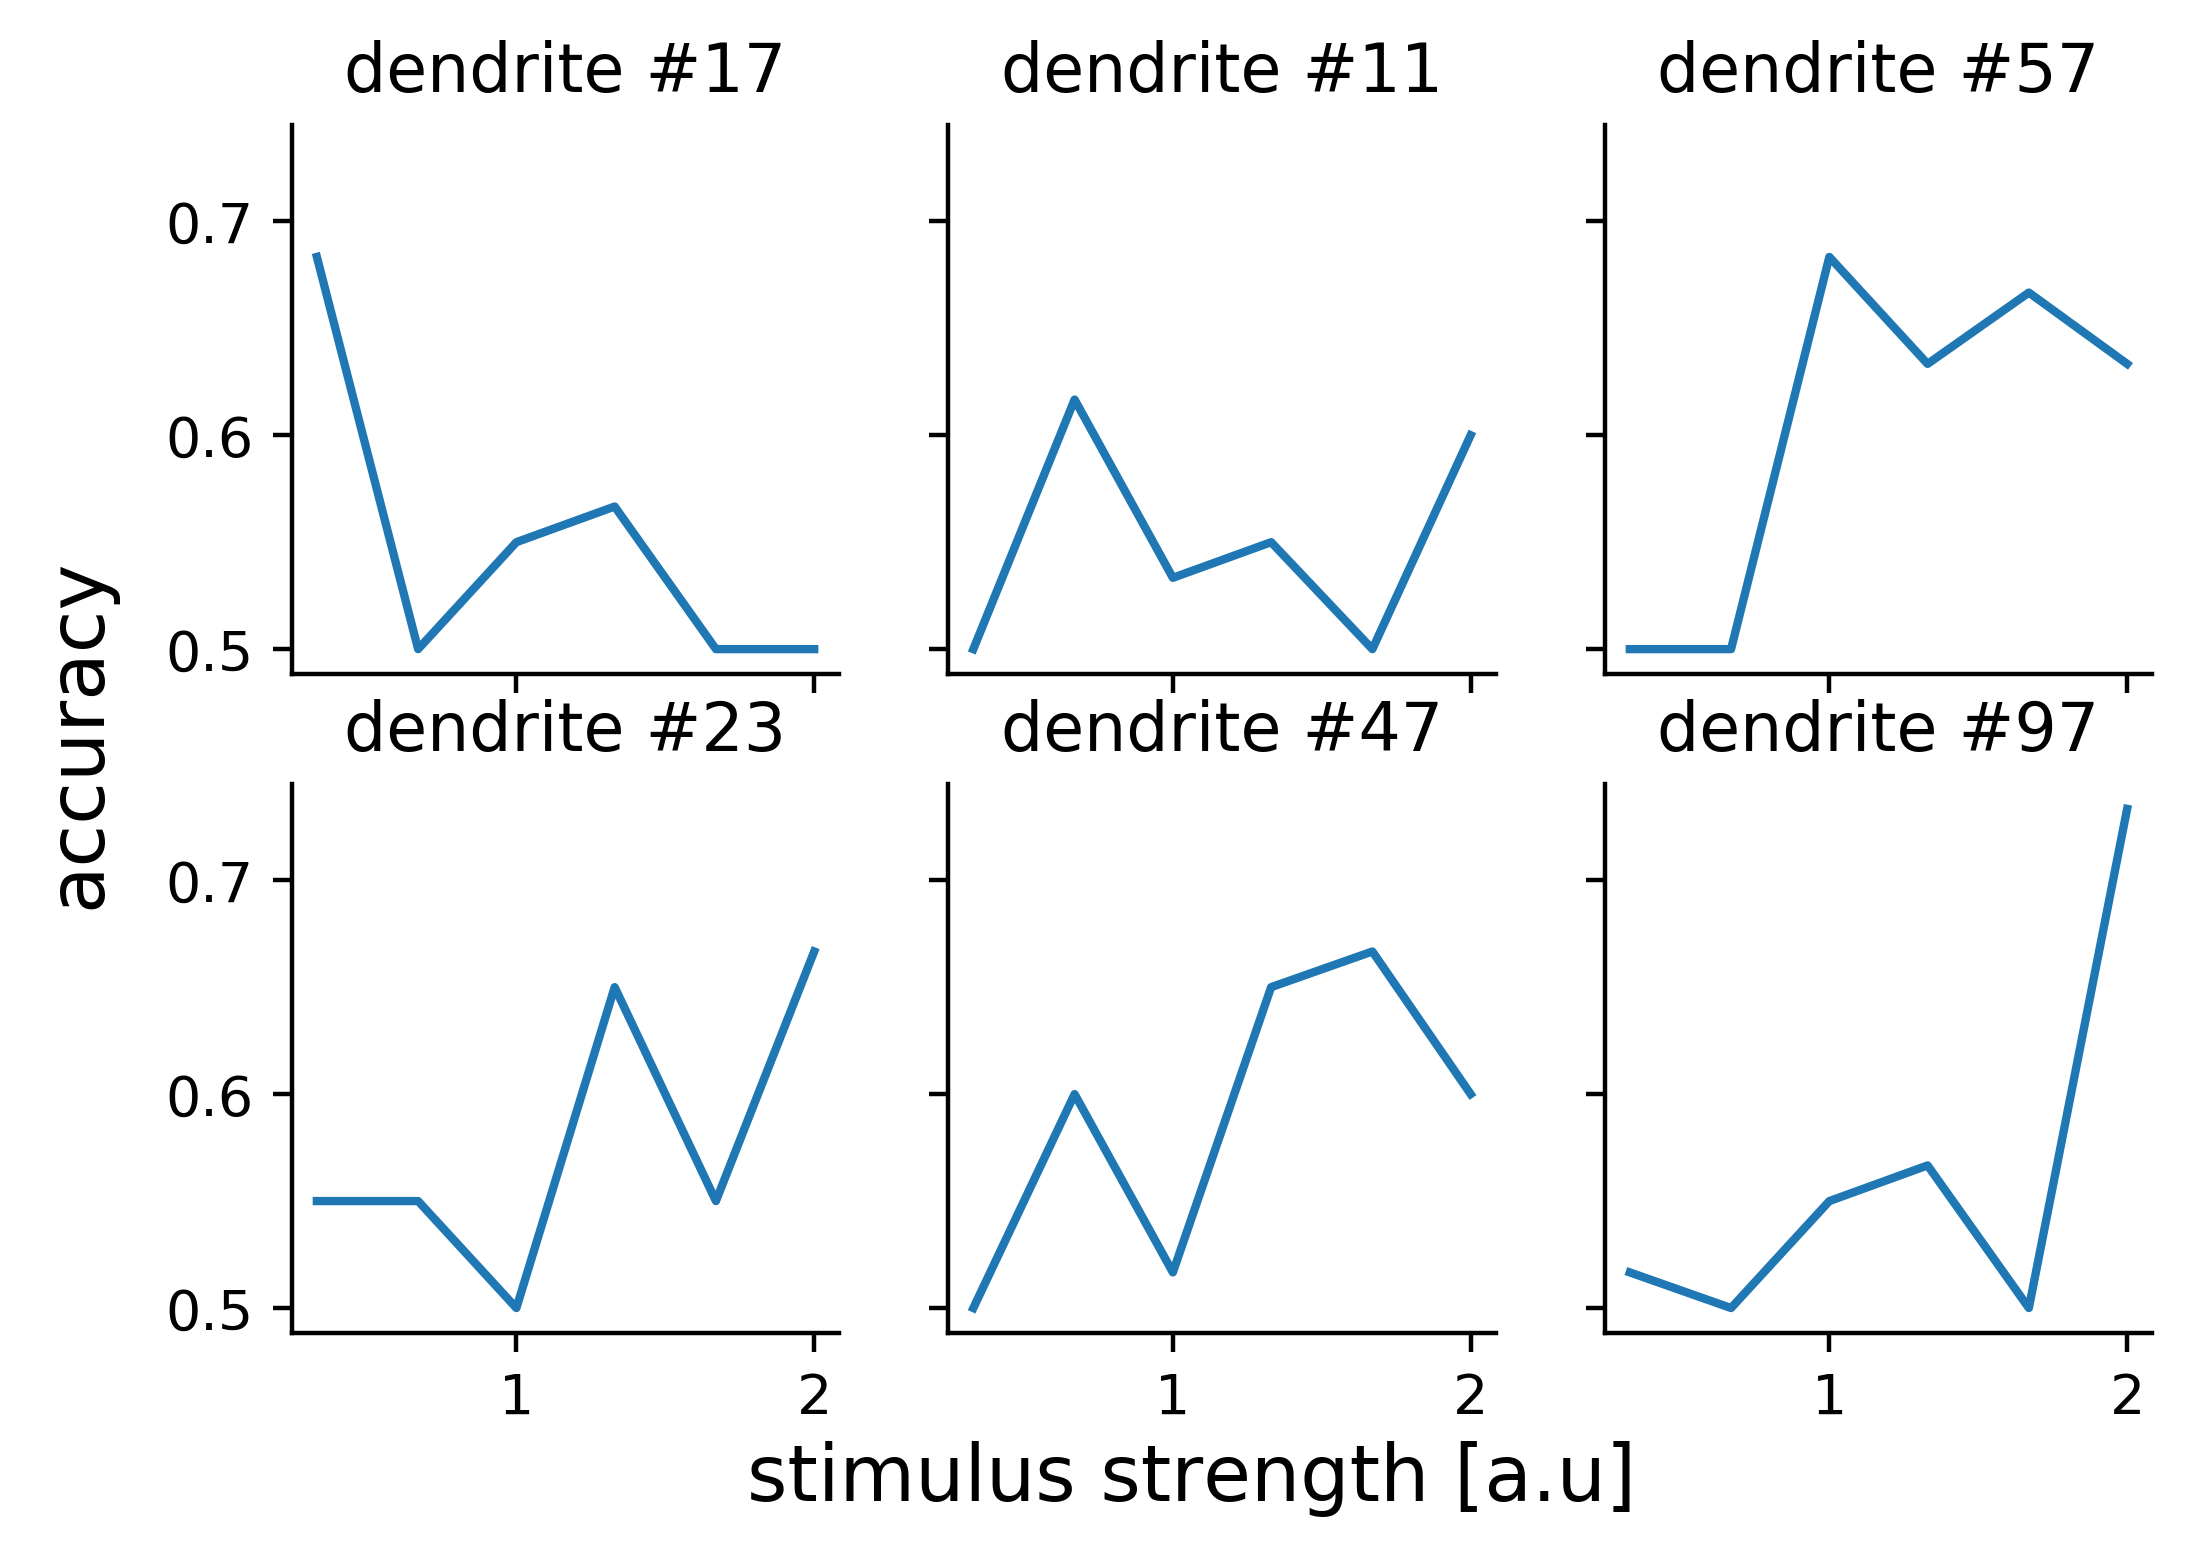

In [318]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=True, sharey=True, dpi=400)
axarr = (ax1, ax2, ax3, ax4, ax5, ax6)

stimss = [0.33,0.67,1,1.33,1.67,2]

for i, ax in enumerate(axarr):
    ax.plot(stimss, scmat[rankmat[-1,i]])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.set_title('dendrite #{0}'.format(str(rankmat[-1,i]+1))[:-2])
    
fig.text(0.5, 0.02, 'stimulus strength [a.u]', ha='center', fontsize=14)
fig.text(0.02, 0.5, 'accuracy', va='center', rotation='vertical', fontsize=14)

fig.savefig('tuning.png')

In [269]:
stdmat = np.std(scmat, axis=1)
std_rank = np.argsort(stdmat)
std_rank

array([34, 42, 67, 69, 53, 71, 62,  5, 75,  7, 43, 48,  6, 29, 19, 61, 63,
       31,  9, 45, 66,  8, 41, 24, 59, 87, 20, 15, 74, 64, 89,  3, 83, 91,
       86, 32, 93, 76, 57, 65, 73, 88, 92, 12, 68, 28, 39, 94, 85, 80, 11,
       70, 84, 60, 51, 77, 82, 33, 27, 95, 37, 54, 72, 35, 78, 36, 21,  0,
       26,  4, 49, 14, 90, 38, 25, 50, 55, 44,  2, 13, 47, 30, 17, 10, 81,
        1, 18, 23, 22, 79, 46, 58, 16, 52, 40, 56, 96])

In [270]:
sig = []
for i in range(scmat.shape[0]):
    if np.sum(scmat[i] > 0.6):
        sig.append(i)
for nr in std_rank:
    if nr in sig:
        print(nr)

27
26
38
55
2
13
47
30
17
10
81
1
18
23
22
79
46
58
16
52
40
56
96


In [213]:
a = np.array([[1,2,3,4,5], [1,1,1,1,1]])
any(a[0]) > 6

False

In [271]:
rankmat

array([[ 33.,  81.,  50.,  68.,  62.,  16.],
       [ 46.,   1.,  15.,  78.,  39.,   1.],
       [ 49.,  66.,  90.,  39.,  48.,  49.],
       [ 92.,  57.,  33.,  53.,  84.,  57.],
       [ 61.,  11.,  66.,  43.,  42.,  71.],
       [ 53.,  68.,  29.,  42.,  85.,   7.],
       [ 69.,  69.,  63.,  48.,  67.,  48.],
       [ 52.,  70.,  67.,  91.,  96.,  42.],
       [ 17.,  74.,   7.,  19.,   5.,  87.],
       [ 90.,  78.,  53.,   6.,  34.,  43.],
       [ 70.,  23.,  76.,  83.,  73.,  62.],
       [ 58.,  52.,  25.,  71.,  16.,  84.],
       [ 67.,  53.,   8.,  59.,  44.,  61.],
       [ 77.,  58.,  35.,  40.,   1.,  38.],
       [ 15.,  92.,  92.,   9.,  53.,  80.],
       [ 86.,  67.,  40.,  44.,  60.,  85.],
       [  5.,  72.,  23.,  67.,  95.,  45.],
       [ 66.,  64.,   5.,  33.,  43.,  37.],
       [ 91.,  83.,  84.,  63.,  59.,  29.],
       [ 23.,  87.,  85.,  51.,  61.,  70.],
       [  7.,  73.,  44.,  89.,  30.,  69.],
       [ 78.,  71.,  36.,  86.,  31.,  15.],
       [ 1

In [45]:
ds_temp = ds

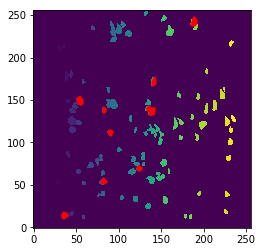

In [46]:
plt.imshow(g['roi'], origin='lower')
for d in ds:
    plt.scatter(g['dend'][d,:,1], g['dend'][d,:,0], s=1, color='r')

(0, 1)

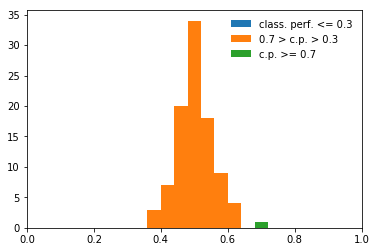

In [47]:
means = np.asarray(means)

lo_mask = means <= 0.3
mid_mask = np.logical_and(means >0.3, means < 0.7)
hi_mask = means >= 0.7

plt.hist(means[lo_mask], bins=50, range=(-1,1), label='class. perf. <= 0.3')
plt.hist(means[mid_mask], bins=50, range=(-1,1), label='0.7 > c.p. > 0.3')
plt.hist(means[hi_mask], bins=50, range=(-1,1), label='c.p. >= 0.7')
plt.legend(frameon=False)
plt.xlim(0,1)

# Ca2+ as a predictor for hit/miss
### all dendrites

In [373]:
def SVM_hitmiss_single(filename, amp, svm_kernel='linear', cv=5):
    '''
    Trains an SVM on the Ca2+ data of single dendrites to detect/predict behavior.
    
    filename: string, name of experiment file
    amp: float, stimulus strength, must exist
    svm_kernel: string, specifies svm kernel to use for training
    cv: int, number of folds for cv
    
    returns: n_dendrites x cv ndarray. Each row holds the accuracy values for each fold for one dendrite.
    '''
    f = h5py.File(filename+".hdf5", "r")
    data = f['data']
    meta = f['meta']
    g = h5py.File(filename[:-6]+"roi.hdf5", "r")
    motion_mask = (g['inFrameDend'][:].astype(bool)).reshape(g['inFrameDend'].shape[0])
    #load data
    
    stims = np.unique(meta[:,1])[:]        #exclude zero-stim-trials
    assert(amp in list(stims)), "this stimAmp was not used in chosen experiment. Cose one from {}.".format(stims)
    #load stimAmps and check whether the chosen amp matches one of them

    n_dendrites = np.sum(motion_mask)
    #get number of dendrites

    clf = svm.SVC(kernel=svm_kernel, class_weight='balanced')
    #classifier. balalced class weights because classes can be very unbalanced

    bals = []
    ns = []    
    sc = np.zeros((n_dendrites, cv))
    #will hold balances, number of samples and scores
    
    for site in range(n_dendrites):

        baseline = np.mean(data[:,motion_mask,:58], axis=2).reshape(data.shape[0], data[:,motion_mask,:].shape[1], 1)
        #baselibe for every trial is the mean over the first second - 58 frames
        
        mn_dnd_chng = np.mean(data[:,motion_mask,58:116]-baseline, axis=2)
        #mean dendritic change = second second minus baseline, mean

        trials_mask = meta[:,1]==amp
        #get mask for trials with chosen amp

        y_score = mn_dnd_chng[trials_mask, site]
        #scores used are mean dendritic changes on trials with chosen stimulus at chosen dendrite

        hit_mask = meta[:, 2]==1
        #mask, true when hit

        end_mask = hit_mask[trials_mask]
        #only use trials with chosen amp
        
        y_true = (end_mask-0.5)*2
        #convert to 1 and -1 values

        balance = np.sum(end_mask)/end_mask.shape[0]
        n_y = end_mask.shape[0]

        bals.append(balance)
        ns.append(n_y)
        #compute and append balances and sample number

        scores = cross_val_score(clf, y_score.reshape(y_score.shape[0], 1), y_true.reshape(y_true.shape[0]), cv=cv)
        sc[site, :] = scores
        
    return sc, bals, ns

In [363]:
filename =filelist[1]
amp = 1

sc, bals, ns = SVM_hitmiss_single(filename, amp, cv=5)

In [364]:
hitmiss_masks = []

In [365]:
n_dendrites = h5py.File(filename+'.hdf5', 'r')['data'].shape[1]
g = h5py.File(filename[:-6]+"roi.hdf5", "r")
motion_mask = (g['inFrameDend'][:].astype(bool)).reshape(g['inFrameDend'].shape[0])

means = np.mean(sc, axis=1)
sdvs = np.std(sc, axis=1)

true_site = 0
for site in range(n_dendrites):
    if motion_mask[site]:
        print("For recording site {0}: accuracy: {1: .2f} (+/- {2: .2f})".format(site, means[true_site], sdvs[true_site]*2))
        true_site += 1
    else:
        print("Site {} was discarded".format(site))
#for site, mean in enumerate(means):
#    print("For recording site {0}: accuracy: {1: .2f} (+/- {2: .2f})".format(site, mean, sdvs[site]*2))

Site 0 was discarded
Site 1 was discarded
Site 2 was discarded
Site 3 was discarded
For recording site 4: accuracy:  0.71 (+/-  0.17)
For recording site 5: accuracy:  0.67 (+/-  0.29)
For recording site 6: accuracy:  0.43 (+/-  0.28)
For recording site 7: accuracy:  0.55 (+/-  0.25)
For recording site 8: accuracy:  0.44 (+/-  0.26)
For recording site 9: accuracy:  0.58 (+/-  0.36)
For recording site 10: accuracy:  0.42 (+/-  0.15)
For recording site 11: accuracy:  0.33 (+/-  0.34)
For recording site 12: accuracy:  0.47 (+/-  0.51)
For recording site 13: accuracy:  0.56 (+/-  0.37)
For recording site 14: accuracy:  0.58 (+/-  0.11)
For recording site 15: accuracy:  0.73 (+/-  0.26)
For recording site 16: accuracy:  0.31 (+/-  0.07)
For recording site 17: accuracy:  0.56 (+/-  0.30)
For recording site 18: accuracy:  0.29 (+/-  0.17)
For recording site 19: accuracy:  0.52 (+/-  0.16)
For recording site 20: accuracy:  0.53 (+/-  0.62)
For recording site 21: accuracy:  0.31 (+/-  0.25)
For 

In [366]:
n_out = 10
inds = np.argsort(means)[::-1]
n_mask = 2
out_mask_hitmiss = np.ones(n_dendrites).astype(bool)
ds_hitmiss = []

print("{} recordings sites best for classification:".format(n_out))
for i in range(n_out):
    c = -1
    for j in range(n_dendrites):
        c += motion_mask[j]
        d = j
        if c == inds[i]:
            break
    if n_mask > 0:
        out_mask_hitmiss[d] = False
        n_mask -= 1
    ds_hitmiss.append(d)
    print("At recording site {0}: accuracy: {1: .2f} (+/- {2: .2f})".format(d, means[inds[i]], sdvs[inds[i]]*2))
hitmiss_masks.append(out_mask_hitmiss)

10 recordings sites best for classification:
At recording site 88: accuracy:  0.80 (+/-  0.15)
At recording site 57: accuracy:  0.80 (+/-  0.15)
At recording site 92: accuracy:  0.78 (+/-  0.12)
At recording site 56: accuracy:  0.76 (+/-  0.19)
At recording site 44: accuracy:  0.76 (+/-  0.06)
At recording site 47: accuracy:  0.76 (+/-  0.06)
At recording site 70: accuracy:  0.73 (+/-  0.11)
At recording site 99: accuracy:  0.73 (+/-  0.14)
At recording site 15: accuracy:  0.73 (+/-  0.26)
At recording site 94: accuracy:  0.72 (+/-  0.22)


In [381]:
filename = filelist[1]
stims = np.unique(h5py.File(filename+'.hdf5', 'r')['meta'][:,1])[:]

scss = []
for amp in stims:
    scs, bals, ns = SVM_hitmiss_single(filename, amp, cv=4)
    scss.append(np.mean(scs, axis=1))

In [382]:
rankmat_b = np.zeros((scs.shape[0],stims.shape[0]))
for k, s in enumerate(scss):
    rankmat_b[:,k] = np.argsort(s)

In [380]:
scmat = np.zeros((scs.shape[0],stims.shape[0]))
for k, s in enumerate(scss):
    scmat[:,k] = s
ms = scmat < 0.5
scmat[ms] = 0.5
scmat

array([[ 0.67537879,  0.68939394,  0.5       ,  0.68598485,  0.53598485,
         0.5       ,  0.5       ],
       [ 0.54848485,  0.55492424,  0.70833333,  0.65265152,  0.55113636,
         0.5       ,  0.5       ],
       [ 0.5530303 ,  0.5       ,  0.5       ,  0.5       ,  0.60227273,
         0.5       ,  0.5       ],
       [ 0.65871212,  0.57575758,  0.63257576,  0.5       ,  0.57954545,
         0.82310606,  0.5469697 ],
       [ 0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.51325758,
         0.5       ,  0.5       ],
       [ 0.64469697,  0.5       ,  0.68560606,  0.64280303,  0.5       ,
         0.5       ,  0.5       ],
       [ 0.75454545,  0.57765152,  0.77651515,  0.5       ,  0.53219697,
         0.5405303 ,  0.54621212],
       [ 0.5       ,  0.57575758,  0.6875    ,  0.5       ,  0.66856061,
         0.5       ,  0.5       ],
       [ 0.5       ,  0.5       ,  0.5       ,  0.60530303,  0.5       ,
         0.75075758,  0.5       ],
       [ 0.5       ,  0.5   

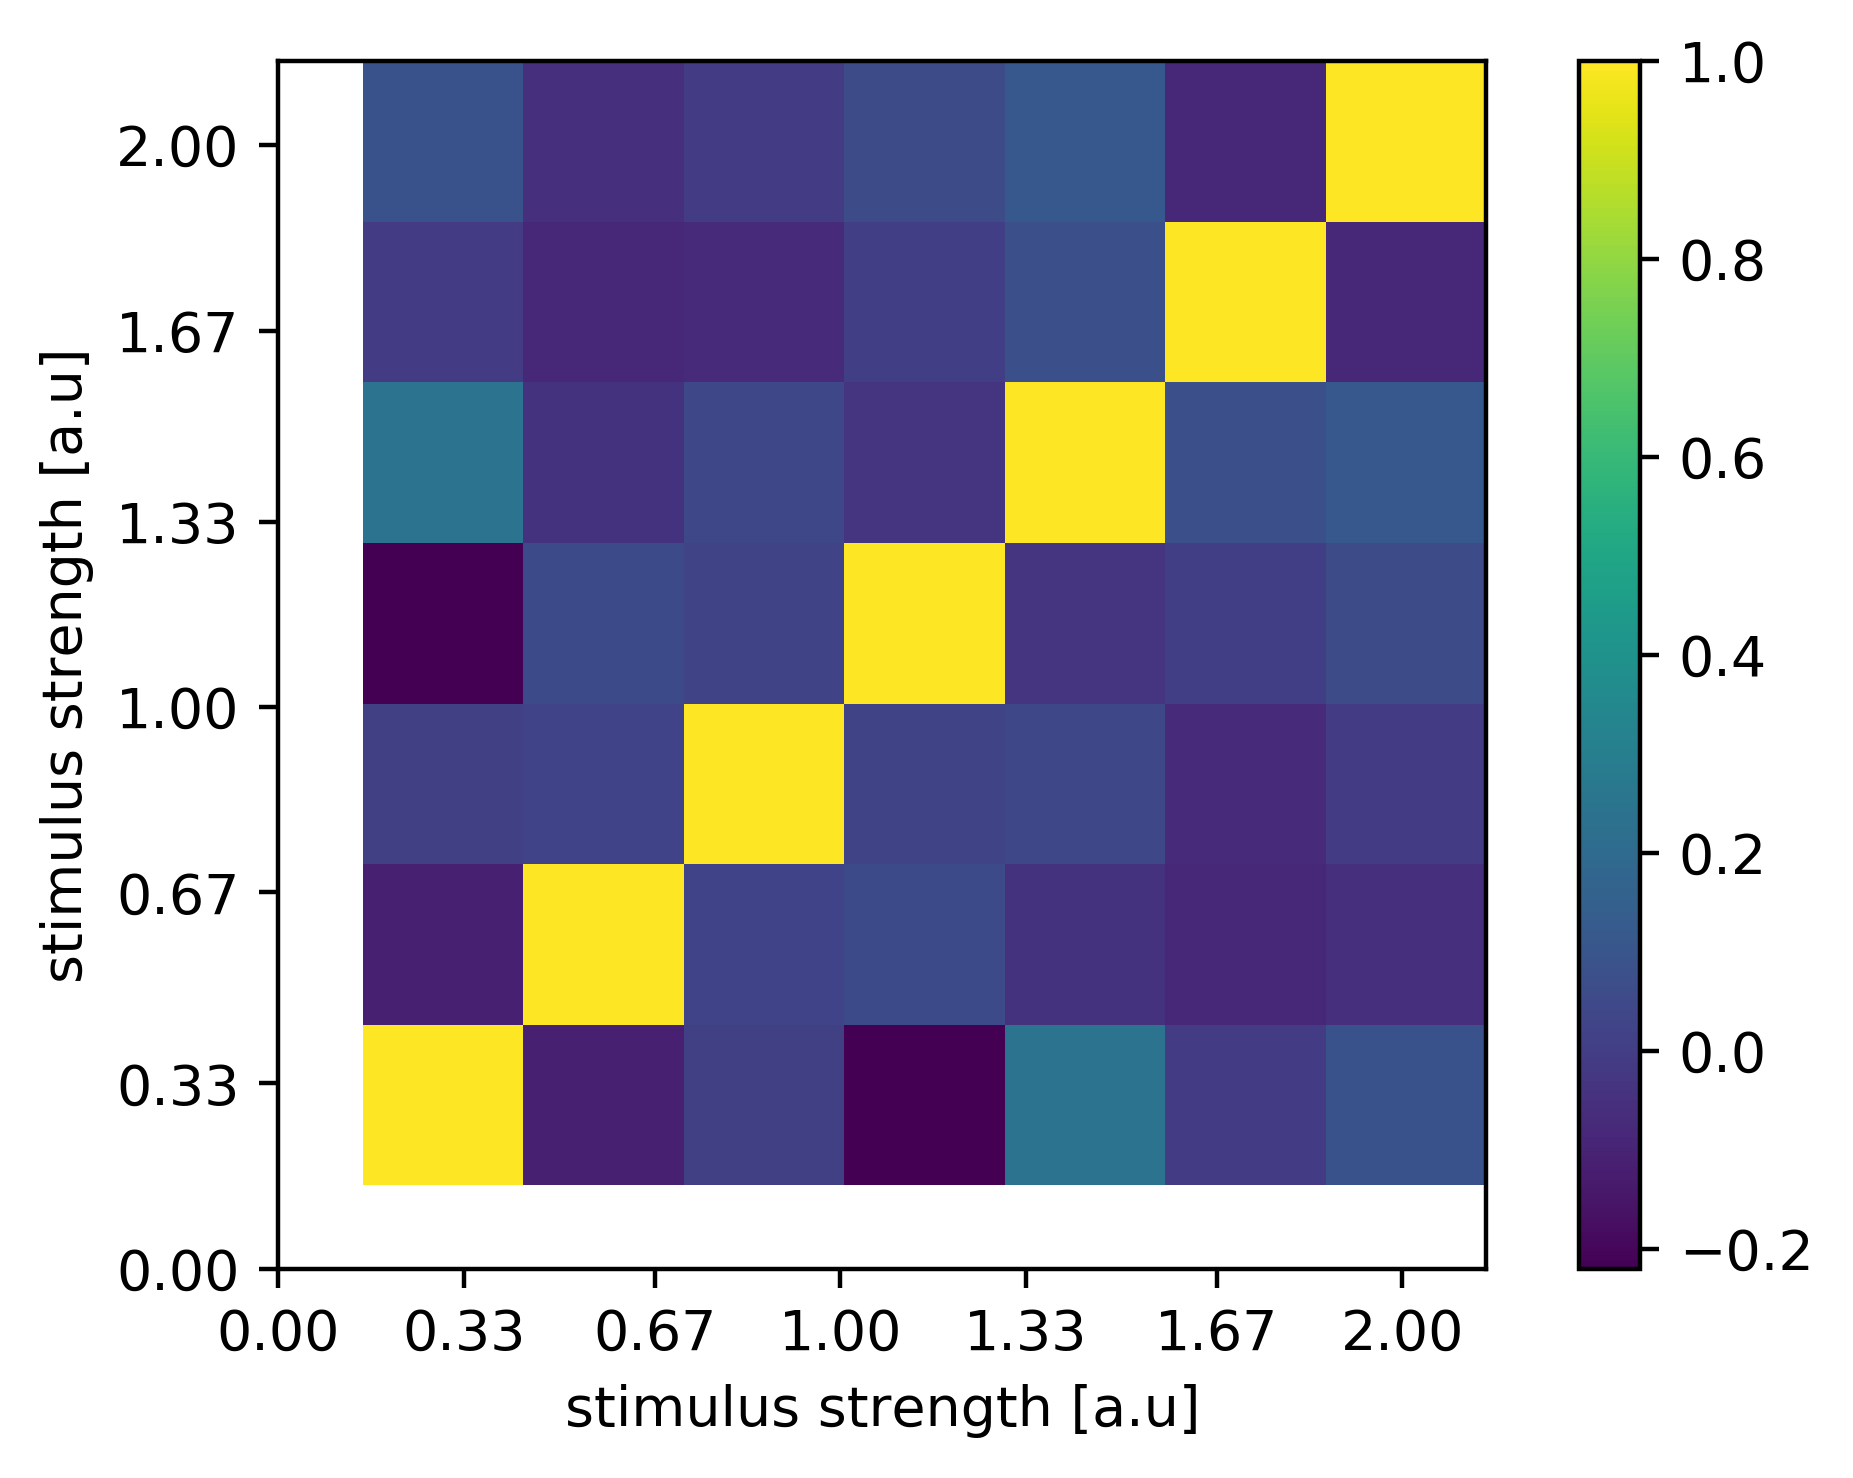

In [383]:
s = np.zeros(stims.shape[0])
for k, amp in enumerate(stims):
    s[k] = '{0: .2f}'.format(amp)

fig = plt.figure(dpi=400) 
    
rho, pval = spearmanr(rankmat_b)
#plt.imshow(rho, extent=[0.33,2,0.33,2])
plt.imshow(rho, extent=[0.15,2.15,0.15,2.15], origin='lower')
plt.xticks(s.astype(float))
plt.yticks(s.astype(float))

#plt.imshow(pval)
plt.colorbar()

plt.xlabel('stimulus strength [a.u]')
plt.ylabel('stimulus strength [a.u]')

fig.savefig('spearman.png')

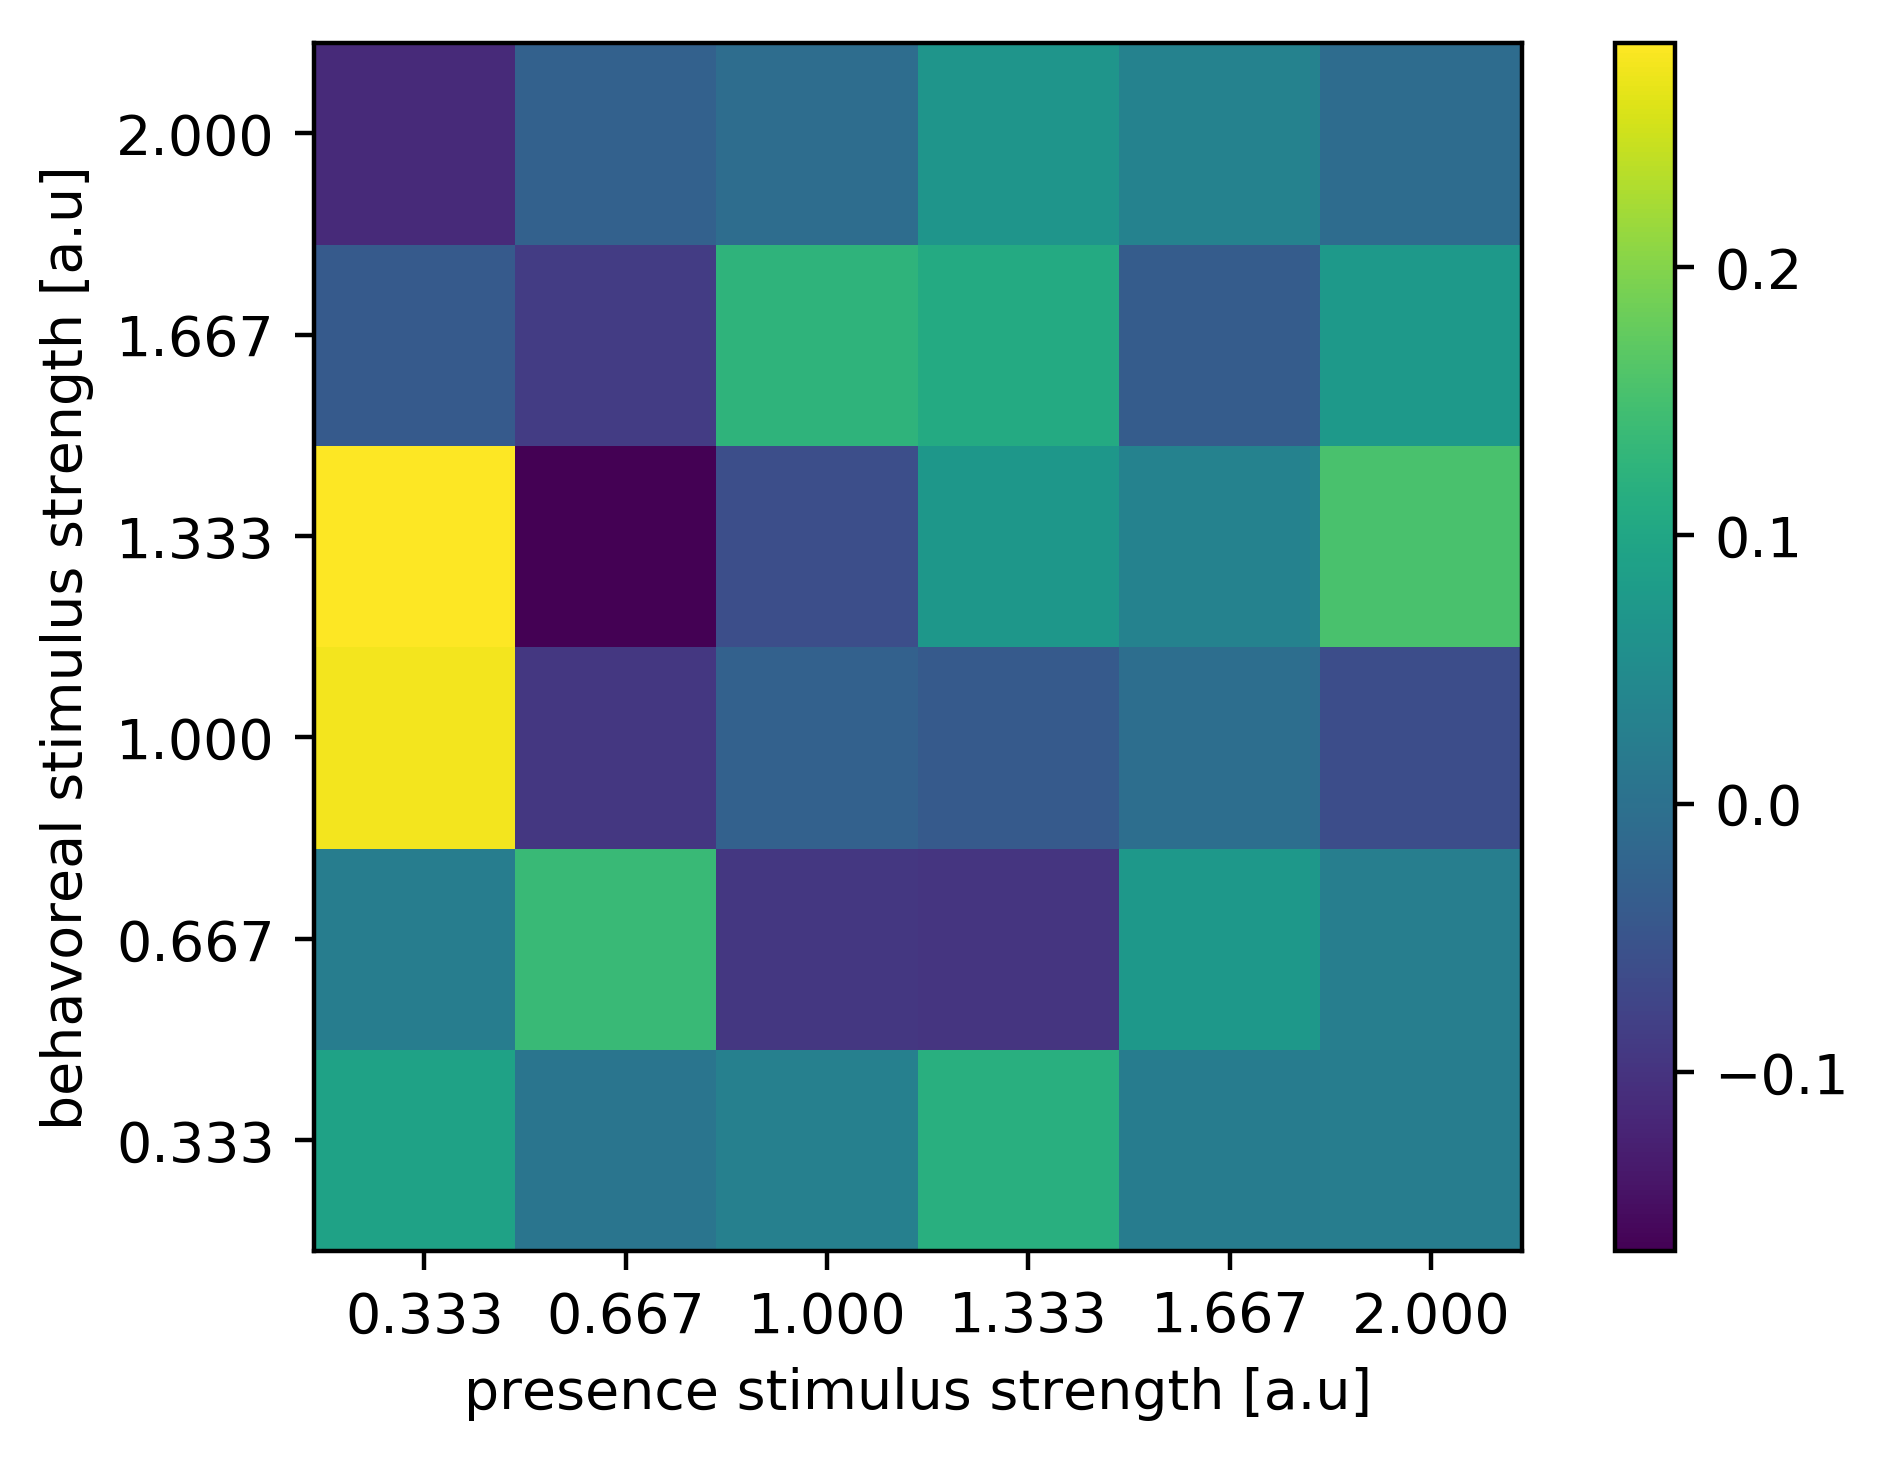

In [405]:
stims = np.unique(h5py.File(filelist[1]+'.hdf5', 'r')['meta'][:,1])[1:]
transmat = np.zeros((6,6))
for i in range(6):
    for j in range(6):
        rho, pval = spearmanr(rankmat[:,i], rankmat_b[:,j+1])
        transmat[i,j] = rho

fig = plt.figure(dpi=400)
plt.imshow(transmat, extent=[0.15,2.15,0.15,2.15], origin='lower')
plt.xticks(stims)
plt.yticks(stims)

#plt.imshow(pval)
plt.colorbar()

plt.xlabel('presence stimulus strength [a.u]')
plt.ylabel('behavoreal stimulus strength [a.u]')

fig.savefig('transrank.png')

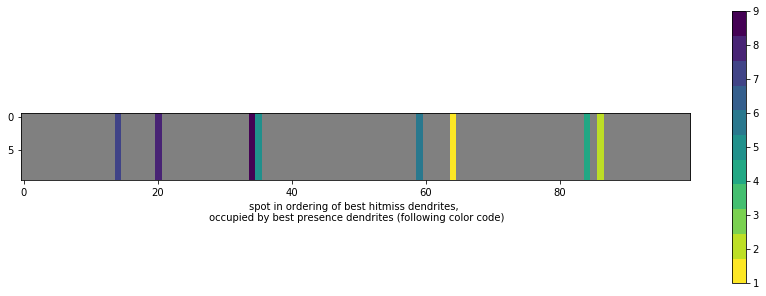

In [115]:
ds_hitmiss_temp = ds_hitmiss

res = np.zeros(100)

for i, ind in enumerate(ds_temp):
    try:
        res[i] = ds_hitmiss_temp.index(ind)
    except ValueError:
        pass
    
res = np.tile(res, (10,1))


plt.figure(figsize=(15,5))
cmap = cm.get_cmap('viridis', 11)
cmap = ListedColormap(cmap.colors[::-1])
cmap.set_under('black', 0.5)
plt.imshow(res, cmap=cmap, vmin=1)

plt.colorbar()

plt.xlabel('spot in ordering of best hitmiss dendrites, \n occupied by best presence dendrites (following color code)')

# Ca2+ as a predictor for stimulus presence
### combination of all dendrites

In [85]:
print(ds)
print(ds_hitmiss_temp)

NameError: name 'ds' is not defined

In [104]:
from sklearn.decomposition import PCA

def do_PCA(X, n_comps=5):
    pca = PCA(n_components=n_comps)
    
    #denoising, but staying in original space!
    X_pca = pca.fit_transform(X)
    
    #return pca.inverse_transform(X_pca), pca
    return X_pca, pca

In [105]:
def SVM_presence_combined(filename, mask=None, svm_kernel='linear', cv=10, z_score=True, C=1, pca=False):
    '''
    Trains an SVM on the Ca2+ data of all dendrites to detect stimulus presence.
    
    filename: string, name of experiment file
    svm_kernel: string, specifies svm kernel to use for training
    cv: int, number of folds for cv
    
    returns: n_stims x cv ndarray. Each row holds the accuracy values for each fold for one stimulus strength.
    '''
    f = h5py.File(filename+".hdf5", "r")
    data = f['data']
    meta = f['meta']
    g = h5py.File(filename[:-6]+"roi.hdf5", "r")
    motion_mask = (g['inFrameDend'][:].astype(bool)).reshape(g['inFrameDend'].shape[0])
    stims = np.unique(meta[:,1])[1:]        #exclude zero
    #load data and stimulia
    
    if mask is not None:
        motion_mask = np.logical_and(motion_mask, mask)
    #using additional dendrite mask if given
    
    sc = np.zeros((stims.shape[0], cv))
    #will hold scores
    
    for i, amp in enumerate(stims):
        baseline = np.mean(data[:,motion_mask,:58], axis=2).reshape(data.shape[0], data[:,motion_mask,:].shape[1], 1)
        #baselibe for every trial is the mean over the first second - 58 frames
        
        mn_dnd_chng_nz = np.mean(data[:,motion_mask,58:116]-baseline, axis=2)
        #mean dendritic change = second second minus baseline, mean
        
        if z_score:
            #mu = np.tile(np.mean(mn_dnd_chng_nz, axis=1).reshape(data.shape[0]), (mn_dnd_chng_nz.shape[1], 1)).T
            #sigma = np.tile(np.std(mn_dnd_chng_nz, axis=1).reshape(data.shape[0]), (mn_dnd_chng_nz.shape[1], 1)).T
            #mn_dnd_chng = (mn_dnd_chng_nz - mu)/sigma
            
            #mu = np.tile(np.mean(mn_dnd_chng_nz, axis=0).reshape(np.sum(motion_mask)), (mn_dnd_chng_nz.shape[0],1))
            #sigma = np.tile(np.std(mn_dnd_chng_nz, axis=0).reshape(np.sum(motion_mask)), (mn_dnd_chng_nz.shape[0],1))
            #mn_dnd_chng = (mn_dnd_chng_nz - mu)/sigma
            mn_dnd_chng = preprocessing.scale(mn_dnd_chng_nz)

        else:
            mn_dnd_chng = mn_dnd_chng_nz
            
        if pca:
            mn_dnd_chng = do_PCA(mn_dnd_chng)[0]

        present_mask = meta[:,1]==amp
        absent_mask = meta[:,1]==0
        #masks for present and absent trials

        trials_mask = np.logical_or(present_mask, absent_mask)
        #combine these to mask of all trials with stimulus zero or the chosen stimulus

        y_score = mn_dnd_chng[trials_mask, :]
        #scores used are mean dendritic changes in chosen trials

        amp_mask = meta[:,1][trials_mask]==amp
        y_true = (amp_mask-0.5)*2
        #stimulus present trials are marked as '1', absent ones as '-1'
        
        ###########
        if amp == 1:
            global _bla_
            _bla_ = y_score
        ###########

        clf = svm.SVC(kernel=svm_kernel, C=C)
        scores = cross_val_score(clf, y_score, y_true.reshape(y_true.shape[0]), cv=cv)
        #make classifier and compute accuracy scores using cross validation
        
        sc[i, :] = scores
    return sc

In [126]:
######################
_bla_ = None
_blb_ = []
######################

filename = filelist[2]
f = h5py.File(filename+".hdf5", "r")
n_dends = f['data'].shape[1]

#dends = [50, 46, 53, 7, 44, 62, 18, 42, 18, 21]
mask = np.zeros(n_dends).astype(bool)
    
meta = f['meta']
stims = np.unique(meta[:,1])[1:]        #exclude zero

amp = 2

scs = SVM_presence_single(filename, stims[amp], scoring='accuracy', cv=10)
n_dendrites = h5py.File(filename+'.hdf5', 'r')['data'].shape[1]
g = h5py.File(filename[:-6]+"roi.hdf5", "r")
motion_mask = (g['inFrameDend'][:].astype(bool)).reshape(g['inFrameDend'].shape[0])

means = np.mean(scs, axis=1)
sdvs = np.std(scs, axis=1)

true_site = 0
for site in range(n_dendrites):
    if motion_mask[site]:
        #print("For recording site {0}: accuracy: {1: .2f} (+/- {2: .2f})".format(site, means[true_site], sdvs[true_site]*2))
        true_site += 1
    else:
        pass
        #print("Site {} was discarded".format(site))
#for site, mean in enumerate(means):
#    print("For recording site {0}: accuracy: {1: .2f} (+/- {2: .2f})".format(site, mean, sdvs[site]*2))
n_mask = 0
out_mask_presence = np.ones(n_dendrites).astype(bool)
n_out = 10
inds = np.argsort(means)[::-1]
ds = []

dends = []
print("{} recordings sites best for classification:".format(n_out))
for i in range(n_out):
    c = -1
    for j in range(n_dendrites):
        c += motion_mask[j]
        d = j
        if c == inds[i]:
            break
    if n_mask > 0:
        out_mask_presence[d] = False
        n_mask -= 1
    ds.append(d)
    dends.append(d)
    print("At recording site {0}: accuracy: {1: .2f} (+/- {2: .2f})".format(d, means[inds[i]], sdvs[inds[i]]*2))
print('-----------------------------------------------------------')
for d in dends:
    mask[d] = True
    
#mask = None
sc = SVM_presence_combined(filename, z_score=True, svm_kernel='linear', mask=mask, cv=10, C=1, pca=False)

for k in [amp]:
    print("For stimApm {0: .2f}: accuracy: {1: .2f} (+/- {2: .2f})".format(stims[k], np.mean(sc[k,:]), 2*np.std(sc[k,:])))


#presence_masks.append(out_mask_presence)

10 recordings sites best for classification:
At recording site 57: accuracy:  0.68 (+/-  0.28)
At recording site 53: accuracy:  0.65 (+/-  0.28)
At recording site 48: accuracy:  0.62 (+/-  0.42)
At recording site 27: accuracy:  0.62 (+/-  0.33)
At recording site 15: accuracy:  0.60 (+/-  0.40)
At recording site 2: accuracy:  0.60 (+/-  0.27)
At recording site 38: accuracy:  0.58 (+/-  0.22)
At recording site 33: accuracy:  0.58 (+/-  0.17)
At recording site 29: accuracy:  0.58 (+/-  0.17)
At recording site 59: accuracy:  0.58 (+/-  0.34)
-----------------------------------------------------------
For stimApm  1.00: accuracy:  0.72 (+/-  0.33)


In [52]:
ff = h5py.File('mask', 'w')
ff['1_3'] = mask
ff.close()

In [94]:
mask = np.zeros(n_dends).astype(bool)
mask[50] = True

site=46

f = h5py.File(filename+".hdf5", "r")
data = f['data']
meta = f['meta']
g = h5py.File(filename[:-6]+"roi.hdf5", "r")
motion_mask = (g['inFrameDend'][:].astype(bool)).reshape(g['inFrameDend'].shape[0])

bl2 = np.mean(data[:,motion_mask,:58], axis=2).reshape(data.shape[0], data[:,motion_mask,:].shape[1], 1)
mn_dnd_chng2 = np.mean(data[:,motion_mask,58:116]-bl2, axis=2)

motion_mask = np.logical_and(motion_mask, mask)

stims = np.unique(meta[:,1])[1:]        #exclude zero

amp = 1

bl1 = np.mean(data[:,motion_mask,:58], axis=2).reshape(data.shape[0], data[:,motion_mask,:].shape[1], 1)
mn_dnd_chng1 = np.mean(data[:,motion_mask,58:116]-bl1, axis=2)

present_mask = meta[:,1]==amp
absent_mask = meta[:,1]==0
#boolean masks of the trials where stimAmp==amp and stimAmp==0

trials_mask = np.logical_or(present_mask, absent_mask)
#boolean mask for all trials where the stimulus is either our chosen one or absent (0)

y_score2 = mn_dnd_chng2[trials_mask, site]
#score that we use for classification - only stimulus present - and absent trials at one dendrite
y_score1 = mn_dnd_chng1[trials_mask, :]


amp_mask = meta[:,1][trials_mask]==amp
y_true = (amp_mask-0.5)*2

#mn_dnd_chng2.shape
do_PCA(mn_dnd_chng2).shape

(315, 12)

In [662]:
clf = svm.SVC(kernel='linear')
scores = cross_val_score(clf, _bla_, y_true.reshape(y_true.shape[0]), cv=10)

a = np.mean(scores)

clf = svm.SVC(kernel='linear')
y_s = _blb_[58]
y_t = y_true
scores = cross_val_score(clf, y_s.reshape(y_s.shape[0], 1), y_t.reshape(y_t.shape[0]), cv=10)

b = np.mean(scores)
print(a)
#_blb_[46]
#_bla_

0.6125


In [395]:
def SVM_presence_combined_clf(filename, mask=None, svm_kernel='linear', cv=10):
    '''
    Trains an SVM on the Ca2+ data of all dendrites to detect stimulus presence.
    
    filename: string, name of experiment file
    svm_kernel: string, specifies svm kernel to use for training
    cv: int, number of folds for cv
    
    returns: n_stims x cv ndarray. Each row holds the accuracy values for each fold for one stimulus strength.
    '''
    f = h5py.File(filename+".hdf5", "r")
    data = f['data']
    meta = f['meta']
    g = h5py.File(filename[:-6]+"roi.hdf5", "r")
    motion_mask = (g['inFrameDend'][:].astype(bool)).reshape(g['inFrameDend'].shape[0])
    stims = np.unique(meta[:,1])[1:]        #exclude zero
    #load data and stimulia
    
    if mask is not None:
        motion_mask = np.logical_and(motion_mask, mask)
    #using additional dendrite mask if given
    
    clfs = []
    
    for i, amp in enumerate(stims):
        baseline = np.mean(data[:,motion_mask,:58], axis=2).reshape(data.shape[0], data[:,motion_mask,:].shape[1], 1)
        #baselibe for every trial is the mean over the first second - 58 frames
        
        mn_dnd_chng = np.mean(data[:,motion_mask,58:116]-baseline, axis=2)
        #mean dendritic change = second second minus baseline, mean

        present_mask = meta[:,1]==amp
        absent_mask = meta[:,1]==0
        #masks for present and absent trials

        trials_mask = np.logical_or(present_mask, absent_mask)
        #combine these to mask of all trials with stimulus zero or the chosen stimulus

        y_score = mn_dnd_chng[trials_mask, :]
        #scores used are mean dendritic changes in chosen trials

        amp_mask = meta[:,1][trials_mask]==amp
        y_true = (amp_mask-0.5)*2
        #stimulus present trials are marked as '1', absent ones as '-1'

        clf = svm.SVC(kernel=svm_kernel)
        clf.fit(y_score, y_true)
        clfs.append(clf)
    return clfs

In [391]:
filename = filelist[1]
f = h5py.File(filename+".hdf5", "r")
n_dends = f['data'].shape[1]

dends = [50, 46, 53, 7, 44, 62, 18, 42, 18, 21]
mask = np.zeros(n_dends).astype(bool)
for d in [99]:
    mask[d] = True

In [392]:
filename = filelist[1]
f = h5py.File(filename+".hdf5", "r")
meta = f['meta']
stims = np.unique(meta[:,1])[1:]        #exclude zero

sc = SVM_presence_combined(filename, z_score=False, svm_kernel='linear', mask=mask)

for k in range(sc.shape[0]):
    print("For stimApm {0: .2f}: accuracy: {1: .2f} (+/- {2: .2f})".format(stims[k], np.mean(sc[k,:]), 2*np.std(sc[k,:])))

(array([99]),)
For stimApm  0.33: accuracy:  0.51 (+/-  0.06)
For stimApm  0.67: accuracy:  0.50 (+/-  0.09)
For stimApm  1.00: accuracy:  0.50 (+/-  0.00)
For stimApm  1.33: accuracy:  0.49 (+/-  0.06)
For stimApm  1.67: accuracy:  0.47 (+/-  0.16)
For stimApm  2.00: accuracy:  0.50 (+/-  0.00)


In [137]:
for k, scores in enumerate(sc):
    print("For stimApm {0: .2f}: accuracy: {1: .2f} (+/- {2: .2f})".format(stims[k], np.mean(scores), 2*np.std(scores)))

For stimApm  0.33: accuracy:  0.50 (+/-  0.34)
For stimApm  0.67: accuracy:  0.48 (+/-  0.36)
For stimApm  1.00: accuracy:  0.47 (+/-  0.46)
For stimApm  1.33: accuracy:  0.51 (+/-  0.28)
For stimApm  1.67: accuracy:  0.48 (+/-  0.27)
For stimApm  2.00: accuracy:  0.60 (+/-  0.27)


<Container object of 3 artists>

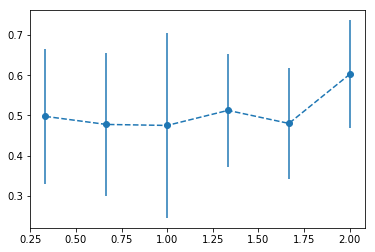

In [138]:
means = np.mean(sc, axis=1)
std = np.std(sc, axis=1)

plt.errorbar(stims, means, yerr=std, fmt='--o')

In [91]:
presence_masks

NameError: name 'presence_masks' is not defined

In [93]:
for i in range(len(presence_masks)):
    sc = SVM_presence_combined(filename, mask=presence_masks[i])
    
    means = np.mean(sc, axis=1)
    std = np.std(sc, axis=1)

    plt.errorbar(stims, means, yerr=std, fmt='--o', label='{} best dendrites removed'.format(i))

    for k in range(sc.shape[0]):
        print("For stimApm {0: .2f}: accuracy: {1: .2f} (+/- {2: .2f})".format(stims[k], np.mean(sc[k,:]), 2*np.std(sc[k,:])))
    print('--------------------------------------------------------------------')    
plt.legend(frameon=False)

NameError: name 'presence_masks' is not defined

# Ca2+ as a predictor for hit/miss
### combination of all dendrites

In [94]:
def SVM_hitmiss_combined(filename, mask=None, svm_kernel='linear', cv=4):
    '''
    Trains an SVM on the Ca2+ data of all dendrites to detect/predict hits/misses.
    
    filename: string, name of experiment file
    svm_kernel: string, specifies svm kernel to use for training
    cv: int, number of folds for cv
    
    returns: n_stims x cv ndarray. Each row holds the accuracy values for each fold for one stimulus strength.
    '''
    f = h5py.File(filename+".hdf5", "r")
    data = f['data']
    meta = f['meta']
    g = h5py.File(filename[:-6]+"roi.hdf5", "r")
    motion_mask = (g['inFrameDend'][:].astype(bool)).reshape(g['inFrameDend'].shape[0])
    stims = np.unique(f['meta'][:,1])        #exclude zero
    #load data and stims
    
    if mask is not None:
        motion_mask = np.logical_and(motion_mask, mask)
    #using additional dendrite mask if given
    
    sc = np.zeros((stims.shape[0], cv))
    bals = []
    ns = []
    #will hold scores, balances and sample numbers
    
    for k, amp in enumerate(stims):
        baseline = np.mean(data[:,motion_mask,:58], axis=2).reshape(data.shape[0], data[:,motion_mask,:].shape[1], 1)
        #baselibe for every trial is the mean over the first second - 58 frames
        
        mn_dnd_chng = np.mean(data[:,motion_mask,58:116]-baseline, axis=2)
        #mean dendritic change = second second minus baseline, mean

        trials_mask = meta[:,1]==amp
        #we use only trials with a given stimulus
        
        y_score = mn_dnd_chng[trials_mask, :]
        #scores are mean dendritic changes in these trials

        hit_mask = meta[:, 2]==1
        #mask of hit-trials

        end_mask = hit_mask[trials_mask]
        #apply trials_mask to hit-mask
        
        y_true = (end_mask-0.5)*2
        #if hit, 1, else -1

        balance = np.sum(end_mask)/end_mask.shape[0]
        n_y = end_mask.shape[0]

        bals.append(balance)
        ns.append(n_y)
        #compute sample numbers and balances

        clf = svm.SVC(kernel=svm_kernel, class_weight='balanced')
        try:
            scores = cross_val_score(clf, y_score, y_true.reshape(y_true.shape[0]), cv=cv)
        except ValueError:
            scores = np.zeros(cv)
        sc[k,:] = scores
        #classifier and scores
        
    return sc, bals, ns

In [95]:
def SVM_hitmiss_combined_clf(filename, mask=None, svm_kernel='linear', cv=4):
    '''
    Trains an SVM on the Ca2+ data of all dendrites to detect/predict hits/misses.
    
    filename: string, name of experiment file
    svm_kernel: string, specifies svm kernel to use for training
    cv: int, number of folds for cv
    
    returns: n_stims x cv ndarray. Each row holds the accuracy values for each fold for one stimulus strength.
    '''
    f = h5py.File(filename+".hdf5", "r")
    data = f['data']
    meta = f['meta']
    g = h5py.File(filename[:-6]+"roi.hdf5", "r")
    motion_mask = (g['inFrameDend'][:].astype(bool)).reshape(g['inFrameDend'].shape[0])
    stims = np.unique(f['meta'][:,1])        #exclude zero
    #load data and stims
    
    if mask is not None:
        motion_mask = np.logical_and(motion_mask, mask)
    #using additional dendrite mask if given
    
    clfs = []
    bals = []
    ns = []
    #will hold scores, balances and sample numbers
    
    for k, amp in enumerate(stims):
        baseline = np.mean(data[:,motion_mask,:58], axis=2).reshape(data.shape[0], data[:,motion_mask,:].shape[1], 1)
        #baselibe for every trial is the mean over the first second - 58 frames
        
        mn_dnd_chng = np.mean(data[:,motion_mask,58:116]-baseline, axis=2)
        #mean dendritic change = second second minus baseline, mean

        trials_mask = meta[:,1]==amp
        #we use only trials with a given stimulus
        
        y_score = mn_dnd_chng[trials_mask, :]
        #scores are mean dendritic changes in these trials

        hit_mask = meta[:, 2]==1
        #mask of hit-trials

        end_mask = hit_mask[trials_mask]
        #apply trials_mask to hit-mask
        
        y_true = (end_mask-0.5)*2
        #if hit, 1, else -1

        balance = np.sum(end_mask)/end_mask.shape[0]
        n_y = end_mask.shape[0]

        bals.append(balance)
        ns.append(n_y)
        #compute sample numbers and balances

        clf = svm.SVC(kernel=svm_kernel, class_weight='balanced')
        clf.fit(y_score, y_true)
        clfs.append(clf)
        
    return clfs, bals, ns

In [103]:
hitmiss_masks.insert(0, None)

For stimApm  0.00: accuracy:  0.92 (+/-  0.01) with  0.08 pos. labels out of 50 ( 4/50)
For stimApm  0.50: accuracy:  0.84 (+/-  0.10) with  0.12 pos. labels out of 50 ( 6/50)
For stimApm  1.00: accuracy:  0.76 (+/-  0.21) with  0.44 pos. labels out of 50 ( 22/50)
For stimApm  1.50: accuracy:  0.66 (+/-  0.13) with  0.70 pos. labels out of 50 ( 35/50)
For stimApm  2.00: accuracy:  0.71 (+/-  0.26) with  0.68 pos. labels out of 50 ( 34/50)
For stimApm  2.50: accuracy:  0.56 (+/-  0.23) with  0.80 pos. labels out of 50 ( 40/50)
For stimApm  3.00: accuracy:  0.76 (+/-  0.19) with  0.86 pos. labels out of 50 ( 43/50)
-----------------------------------------------------------------------


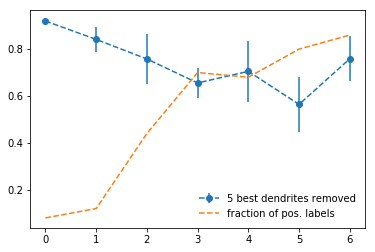

In [97]:
filename = filelist[0]
f = h5py.File(filename+".hdf5", "r")
meta = f['meta']
stims = np.unique(meta[:,1])        #exclude zero

sc, bals, ns = SVM_hitmiss_combined(filename)

means = np.mean(sc, axis=1)
std = np.std(sc, axis=1)

plt.errorbar(np.arange(0,7), means, yerr=std, fmt='--o', label='{} best dendrites removed'.format(i))

for k in range(sc.shape[0]):
    print("For stimApm {0: .2f}: accuracy: {1: .2f} (+/- {2: .2f}) with {3: .2f} pos. labels out of {4} ({5: .0f}/{6})".format(stims[k], np.mean(sc[k,:]), 2*np.std(sc[k,:]), bals[k], ns[k], bals[k]*ns[k], ns[k]))
print('-----------------------------------------------------------------------')
plt.errorbar(np.arange(0,7), bals, fmt='--', label='fraction of pos. labels')
plt.legend(frameon=False)

In [96]:
filename = filelist[0]
f = h5py.File(filename+".hdf5", "r")
meta = f['meta']
stims = np.unique(meta[:,1])        #exclude zero

for i in range(len(hitmiss_masks)):
    sc, bals, ns = SVM_hitmiss_combined(filename, mask=hitmiss_masks[i])
    
    means = np.mean(sc, axis=1)
    std = np.std(sc, axis=1)

    plt.errorbar(np.arange(0,7), means, yerr=std, fmt='--o', label='{} best dendrites removed'.format(i))

    for k in range(sc.shape[0]):
        print("For stimApm {0: .2f}: accuracy: {1: .2f} (+/- {2: .2f}) with {3: .2f} pos. labels out of {4} ({5: .0f}/{6})".format(stims[k], np.mean(sc[k,:]), 2*np.std(sc[k,:]), bals[k], ns[k], bals[k]*ns[k], ns[k]))
    print('-----------------------------------------------------------------------')
plt.errorbar(np.arange(0,7), bals, fmt='--', label='fraction of pos. labels')
plt.legend(frameon=False)

NameError: name 'hitmiss_masks' is not defined

# Comparison of averaging windows, hit/miss

# Comparisom of averaging windows, stimulus presence
### how to go about baseline?

In [3]:
def SVM_hitmiss_combined_window(filename, start, stop, base='frac', svm_kernel='linear', cv=4):
    '''
    Trains an SVM on the Ca2+ data of all dendrites to detect/predict hits/misses.
    
    filename: string, name of experiment file
    start: int, starting frame of averaging window
    stop: int, final frame of averaging window
    base: string, mode of subtracting baseline.
        'normal': always subtract full baseline
        'frac': subtract baseline proportional to fraction of post-stiumulus frames
    svm_kernel: string, specifies svm kernel to use for training
    cv: int, number of folds for cv
    
    returns: n_stims x cv ndarray. Each row holds the accuracy values for each fold for one stimulus strength.
    '''
    assert(stop > start), "window needs to have positive size."
    assert(start >= 0), "start needs to be larger or equal to zero."
    
    f = h5py.File(filename+".hdf5", "r")
    data = smoothen(filename)
    #data = f['data']
    meta = f['meta']
    g = h5py.File(filename[:-6]+"roi.hdf5", "r")
    motion_mask = (g['inFrameDend'][:].astype(bool)).reshape(g['inFrameDend'].shape[0])
    stims = np.unique(f['meta'][:,1])
    #load data and stims
    
    assert(stop <= data.shape[2]), "Stop has to be smaller or equal to the number of frames"
    
    sc = np.zeros((stims.shape[0], cv))
    #will hold scores
    
    for k, amp in enumerate(stims):
        baseline = np.mean(data[:,motion_mask,:58], axis=2).reshape(data.shape[0], data[:,motion_mask,:].shape[1], 1)
        #baselibe for every trial is the mean over the first second - 58 frames
        
        #for 'frac' mode, make the weighting of the baseline proportional the the fraction of post stimulus frames
        if base == 'normal':
            bl_factor = 1
        if base == 'frac':
            n_pre = 58 - start
            n_post = stop - 58
            
            bl_factor = n_post/(n_pre + n_post)
            #compute baseline weight
            
            if n_pre <= 0:
                #start >= 58 -> everything is post stimulus
                bl_factor = 1
            if n_post <= 0:
                #stop <= 50 -> everything is pre-stimulus
                bl_factor = 0
        
        mn_dnd_chng = np.mean(data[:,motion_mask,start:stop]-baseline*bl_factor, axis=2)
        #mean dendritic change = second second minus baseline, mean

        trials_mask = meta[:,1]==amp
        #we use only trials with a given stimulus
        
        y_score = mn_dnd_chng[trials_mask, :]
        #scores are mean dendritic changes in these trials

        hit_mask = meta[:, 2]==1
        #mask of hit-trials

        end_mask = hit_mask[trials_mask]
        #apply trials_mask to hit-mask
        
        y_true = (end_mask-0.5)*2
        #if hit, 1, else -1

        clf = svm.SVC(kernel=svm_kernel, class_weight='balanced')
        try:
            scores = cross_val_score(clf, y_score, y_true.reshape(y_true.shape[0]), cv=cv)
        except ValueError:
            scores = np.zeros(cv)
        sc[k,:] = scores
        #classifier and scores. If not enough instances of either class, return all zeros and continue loop.
        
    return sc

In [4]:
scss = []
for filename in filelist:
    f = h5py.File(filename+".hdf5", "r")

    n_stims = np.unique(f['meta'][:,1]).shape[0]
    cv = 4

    starts = np.arange(0, f['data'].shape[2], 2)
    av_times = np.arange(0, 118, 2) + 1

    scs = np.zeros((starts.shape[0], av_times.shape[0], n_stims, cv))
    for i, start in enumerate(starts):
        print('Computing iteration {} out of {}.'.format(i+1, starts.shape[0]))
        for j, av_time in enumerate(av_times):
            stop = start + av_time
            try:
                sc = SVM_hitmiss_combined_window(filename, start, stop, cv=cv)
                scs[i, j, :, :] = sc
            except:
                scs[i, j, :, :] = np.zeros((n_stims, cv))
    scss.append(scs)

Computing iteration 1 out of 90.
Computing iteration 2 out of 90.
Computing iteration 3 out of 90.
Computing iteration 4 out of 90.
Computing iteration 5 out of 90.
Computing iteration 6 out of 90.
Computing iteration 7 out of 90.
Computing iteration 8 out of 90.
Computing iteration 9 out of 90.
Computing iteration 10 out of 90.
Computing iteration 11 out of 90.
Computing iteration 12 out of 90.
Computing iteration 13 out of 90.
Computing iteration 14 out of 90.
Computing iteration 15 out of 90.
Computing iteration 16 out of 90.
Computing iteration 17 out of 90.
Computing iteration 18 out of 90.
Computing iteration 19 out of 90.
Computing iteration 20 out of 90.
Computing iteration 21 out of 90.
Computing iteration 22 out of 90.
Computing iteration 23 out of 90.
Computing iteration 24 out of 90.
Computing iteration 25 out of 90.
Computing iteration 26 out of 90.
Computing iteration 27 out of 90.
Computing iteration 28 out of 90.
Computing iteration 29 out of 90.
Computing iteration 30 

/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 2 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 3 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 4 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 5 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 6 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 7 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 8 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 9 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 10 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 11 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 12 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 13 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 14 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 15 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 16 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 17 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 18 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 19 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 20 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 21 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 22 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 23 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 24 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 25 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 26 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 27 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 28 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 29 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 30 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 31 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 32 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 33 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 34 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 35 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 36 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 37 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 38 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 39 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 40 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 41 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 42 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 43 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 44 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 45 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 46 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 47 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 48 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 49 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 50 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 51 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 52 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 53 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 54 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 55 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 56 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 57 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 58 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 59 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 60 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 61 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 62 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 63 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 64 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 65 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 66 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 67 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 68 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 69 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 70 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 71 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 72 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 73 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 74 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 75 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 76 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 77 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 78 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 79 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 80 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 81 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 82 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 83 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 84 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 85 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 86 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 87 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 88 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 89 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 90 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


Computing iteration 1 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 2 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 3 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 4 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 5 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 6 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 7 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 8 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 9 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 10 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 11 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 12 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 13 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 14 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 15 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 16 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 17 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 18 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 19 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 20 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 21 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 22 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 23 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 24 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 25 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 26 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 27 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 28 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 29 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 30 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 31 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 32 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 33 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 34 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 35 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 36 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 37 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 38 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 39 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 40 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 41 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 42 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 43 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 44 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 45 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 46 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 47 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 48 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 49 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 50 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 51 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 52 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 53 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 54 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 55 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 56 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 57 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 58 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 59 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 60 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 61 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 62 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 63 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 64 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 65 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 66 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 67 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 68 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 69 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 70 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 71 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 72 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 73 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 74 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 75 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 76 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 77 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 78 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 79 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 80 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 81 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 82 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 83 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 84 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 85 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 86 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 87 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 membe

Computing iteration 88 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


Computing iteration 89 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


Computing iteration 90 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


Computing iteration 1 out of 90.
Computing iteration 2 out of 90.
Computing iteration 3 out of 90.
Computing iteration 4 out of 90.
Computing iteration 5 out of 90.
Computing iteration 6 out of 90.
Computing iteration 7 out of 90.
Computing iteration 8 out of 90.
Computing iteration 9 out of 90.
Computing iteration 10 out of 90.
Computing iteration 11 out of 90.
Computing iteration 12 out of 90.
Computing iteration 13 out of 90.
Computing iteration 14 out of 90.
Computing iteration 15 out of 90.
Computing iteration 16 out of 90.
Computing iteration 17 out of 90.
Computing iteration 18 out of 90.
Computing iteration 19 out of 90.
Computing iteration 20 out of 90.
Computing iteration 21 out of 90.
Computing iteration 22 out of 90.
Computing iteration 23 out of 90.
Computing iteration 24 out of 90.
Computing iteration 25 out of 90.
Computing iteration 26 out of 90.
Computing iteration 27 out of 90.
Computing iteration 28 out of 90.
Computing iteration 29 out of 90.
Computing iteration 30 

/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 2 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 3 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 4 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 5 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 6 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 7 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 8 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 9 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 10 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 11 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 12 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 13 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 14 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 15 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 16 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 17 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 18 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 19 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 20 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 21 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 22 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 23 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 24 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 25 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 26 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 27 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 28 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 29 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 30 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 31 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 32 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 33 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 34 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 35 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 36 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 37 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 38 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 39 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 40 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 41 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 42 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 43 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 44 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 45 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 46 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 47 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 48 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 49 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 50 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 51 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 52 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 53 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 54 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 55 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 56 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 57 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 58 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 59 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 60 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 61 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 62 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 63 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 64 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 65 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 66 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 67 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 68 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 69 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 70 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 71 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 72 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 73 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 74 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 75 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 76 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 77 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 78 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 79 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 80 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 81 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 82 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 83 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 84 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 85 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 86 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 87 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 membe

Computing iteration 88 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


Computing iteration 89 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


Computing iteration 90 out of 90.


/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


Computing iteration 1 out of 90.
Computing iteration 2 out of 90.
Computing iteration 3 out of 90.
Computing iteration 4 out of 90.
Computing iteration 5 out of 90.
Computing iteration 6 out of 90.
Computing iteration 7 out of 90.
Computing iteration 8 out of 90.
Computing iteration 9 out of 90.
Computing iteration 10 out of 90.
Computing iteration 11 out of 90.
Computing iteration 12 out of 90.
Computing iteration 13 out of 90.
Computing iteration 14 out of 90.
Computing iteration 15 out of 90.
Computing iteration 16 out of 90.
Computing iteration 17 out of 90.
Computing iteration 18 out of 90.
Computing iteration 19 out of 90.
Computing iteration 20 out of 90.
Computing iteration 21 out of 90.
Computing iteration 22 out of 90.
Computing iteration 23 out of 90.
Computing iteration 24 out of 90.
Computing iteration 25 out of 90.
Computing iteration 26 out of 90.
Computing iteration 27 out of 90.
Computing iteration 28 out of 90.
Computing iteration 29 out of 90.
Computing iteration 30 

In [6]:
f = h5py.File('window_scores', 'w-')
for i, filename in enumerate(filelist):
    f[filename] = scss[i]
f.close()

In [ ]:
g = h5py.File('n_hitmisses', 'w-')

for filename in filelist:
    f = h5py.File(filename+".hdf5", "r")
    meta = f['meta']
    stims = np.unique(meta[:,1])
    
    hitmisses = np.zeros((stims.shape[0], 2))
    for i, amp in enumerate(stims):
        trials_mask = meta[:,1]==amp
        hit_mask = meta[:, 2]==1
        end_mask = hit_mask[trials_mask]
        y_true = (end_mask-0.5)*2
        n_hits = np.sum(y_true == 1)
        n_misses = np.sum(y_true == -1)
        
        hitmisses[i, 0] = n_hits
        hitmisses[i, 1] = n_misses
    g[filename] = hitmisses
g.close()

In [140]:
f = h5py.File('window_scores', 'r')
g = h5py.File('n_hitmisses', 'r')
thresh = 0.1
summed = np.zeros((7, f[filelist[0]].shape[0], f[filelist[0]].shape[1]))
n_summands = np.ones(7)*len(filelist)
for i in range(7):
    for filename in filelist:
        m_scs = np.mean(f[filename], axis=3)
        if not (g[filename][i,0]/(g[filename][i,0] + g[filename][i,1]) < thresh or g[filename][i,1]/(g[filename][i,0] + g[filename][i,1]) < thresh):
            summed[i] += m_scs[:,:,i]
        else:
            n_summands[i] -= 1
            
f.close()
g.close()
            
for i in range(7):
    summed[i] = summed[i]/n_summands[i]

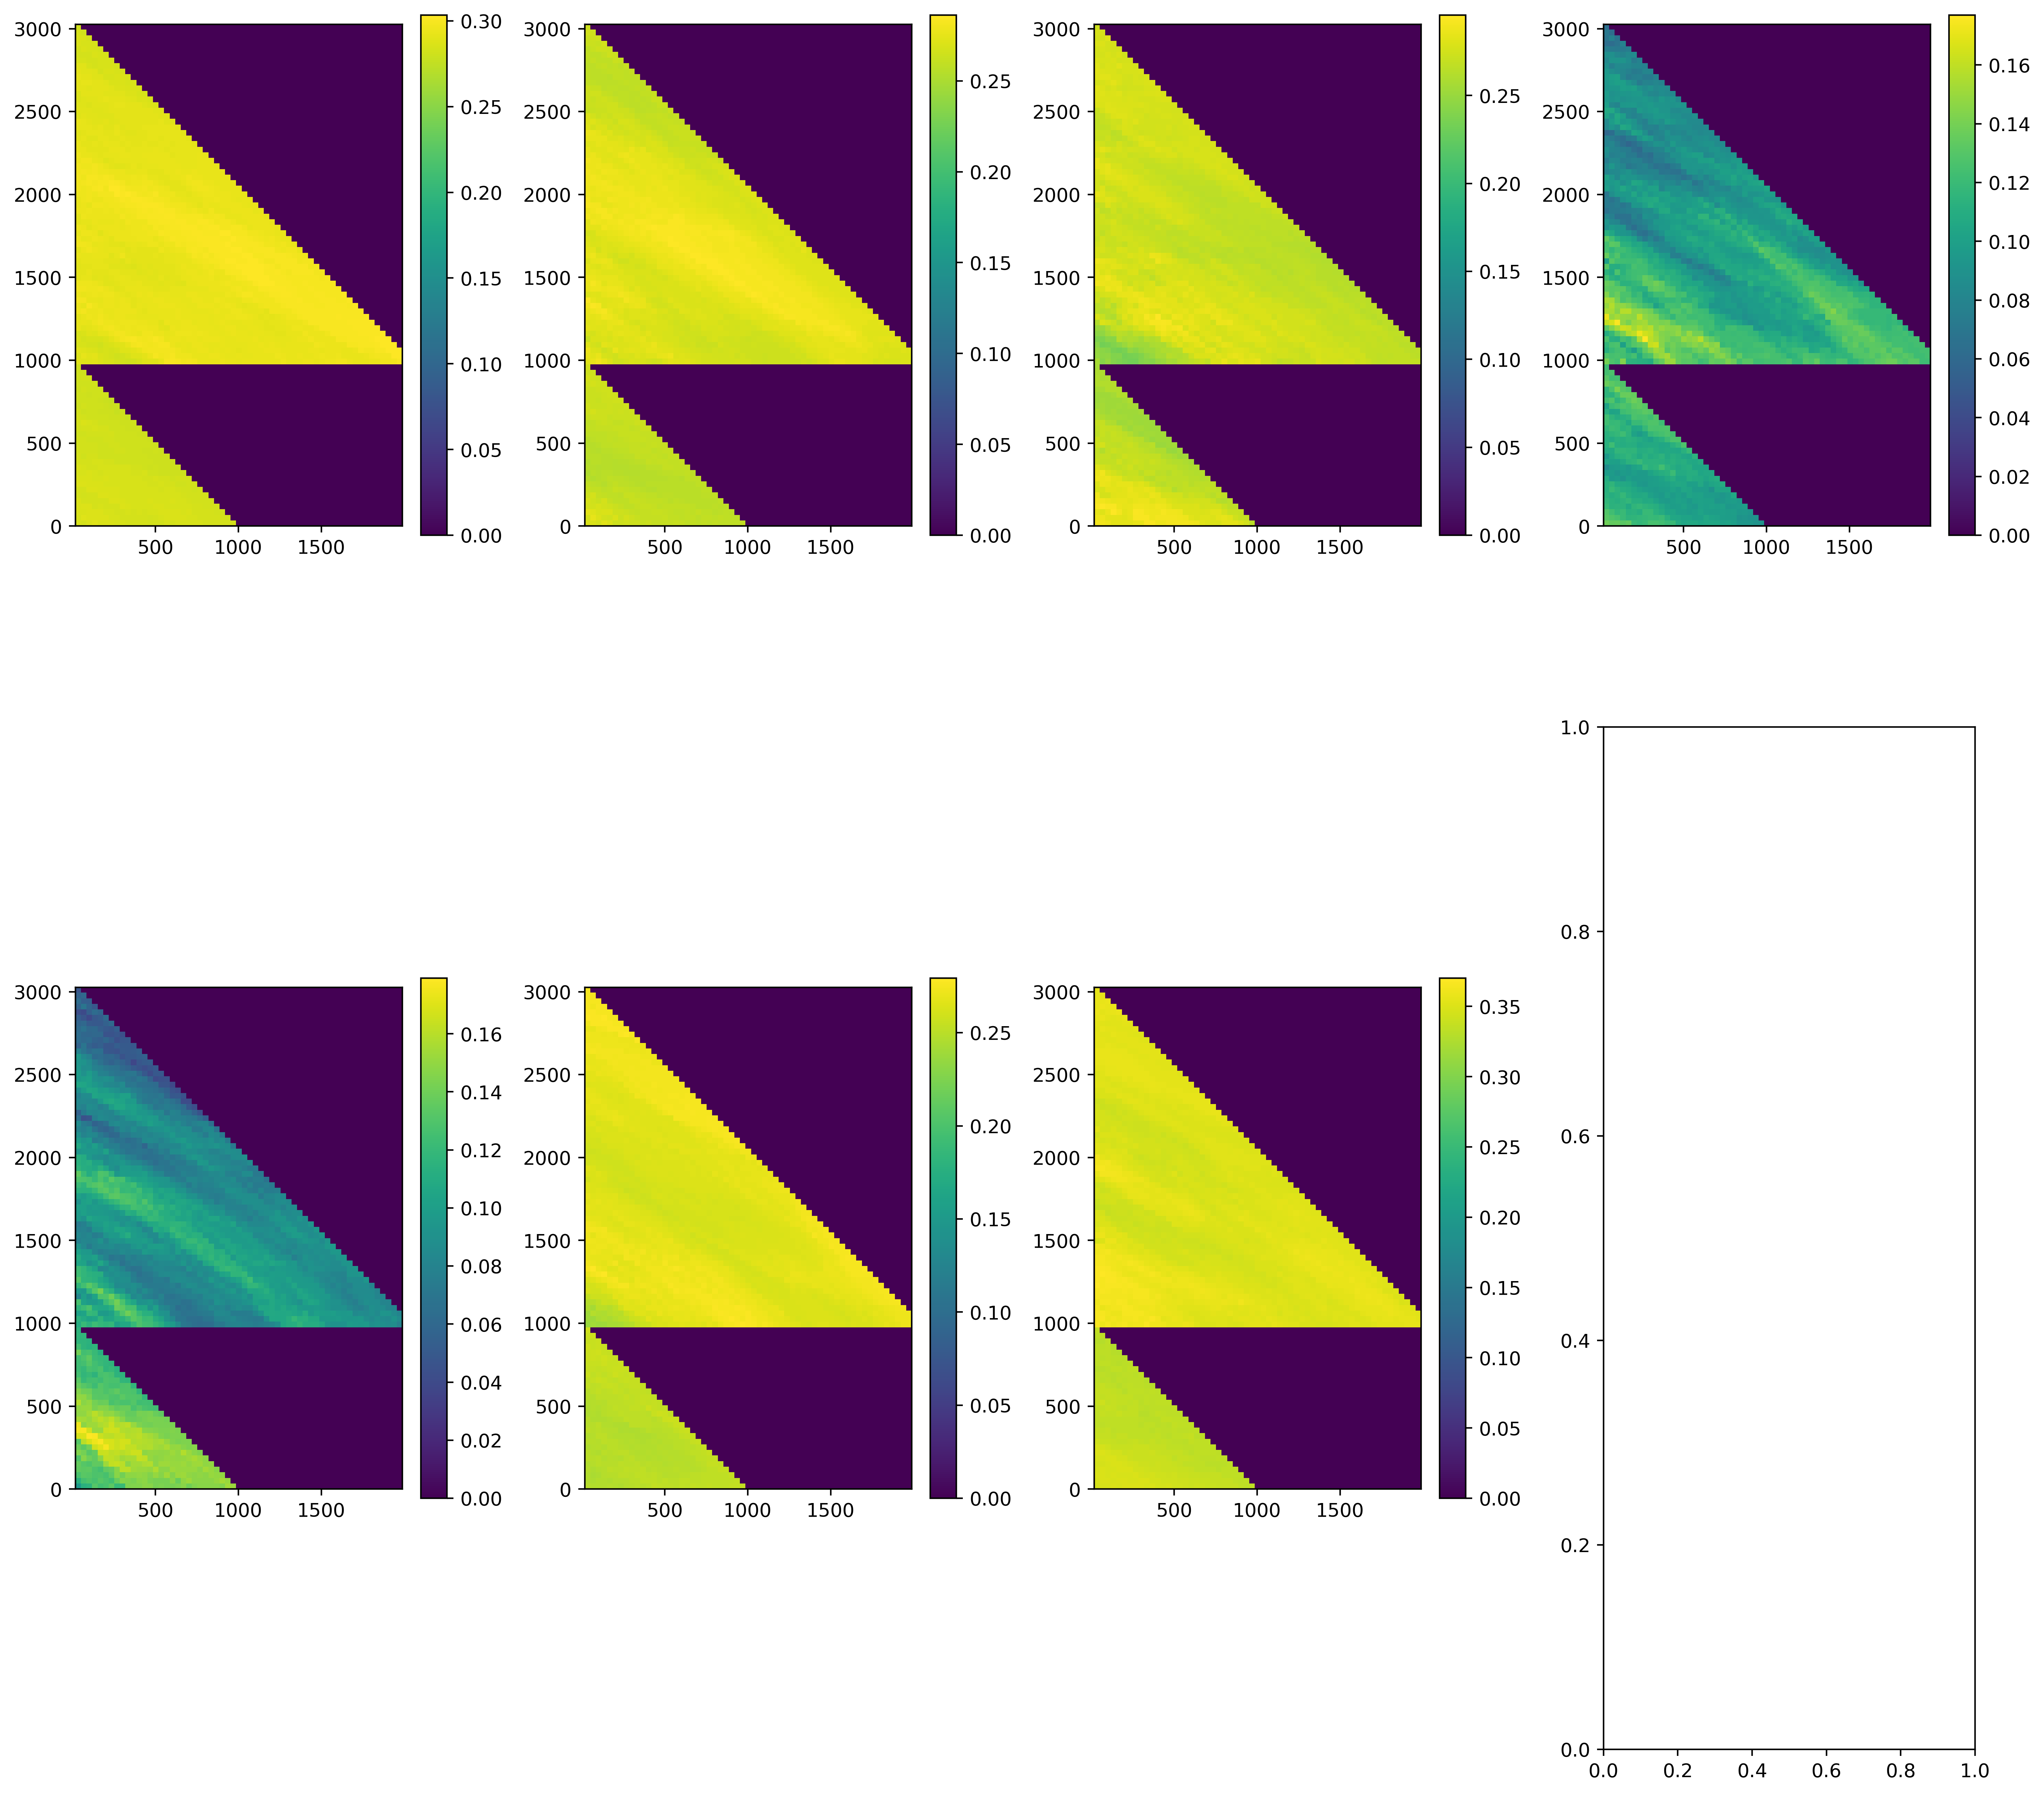

In [142]:
f = h5py.File('window_scores', 'r')
fac = 17
mns=[]
for a in range(8):
    mn = np.mean(f[filelist[a]], axis=3)
    for i in range(mn.shape[0]):
        for j in range(mn.shape[1]):
            if i < 29 and i > 29 - (j + 1):
                mn[i, j, :] = np.zeros(7)
    mns.append(mn)
mns = np.array(mns)
stds = np.std(mns, axis=0)

vmin = np.min(stds.flatten())
vmax = np.max(stds.flatten())

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(15,15), dpi=400)
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

for i, ax in enumerate(axes):
    im = ax.imshow(stds[:,:,i], origin='lower', extent=[1*fac,117*fac, 0*fac, 178*fac])#, vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=ax, fraction=0.07)
    
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=axc1)
#fig.colorbar(im, cax=axc2)
plt.tight_layout()
f.close()

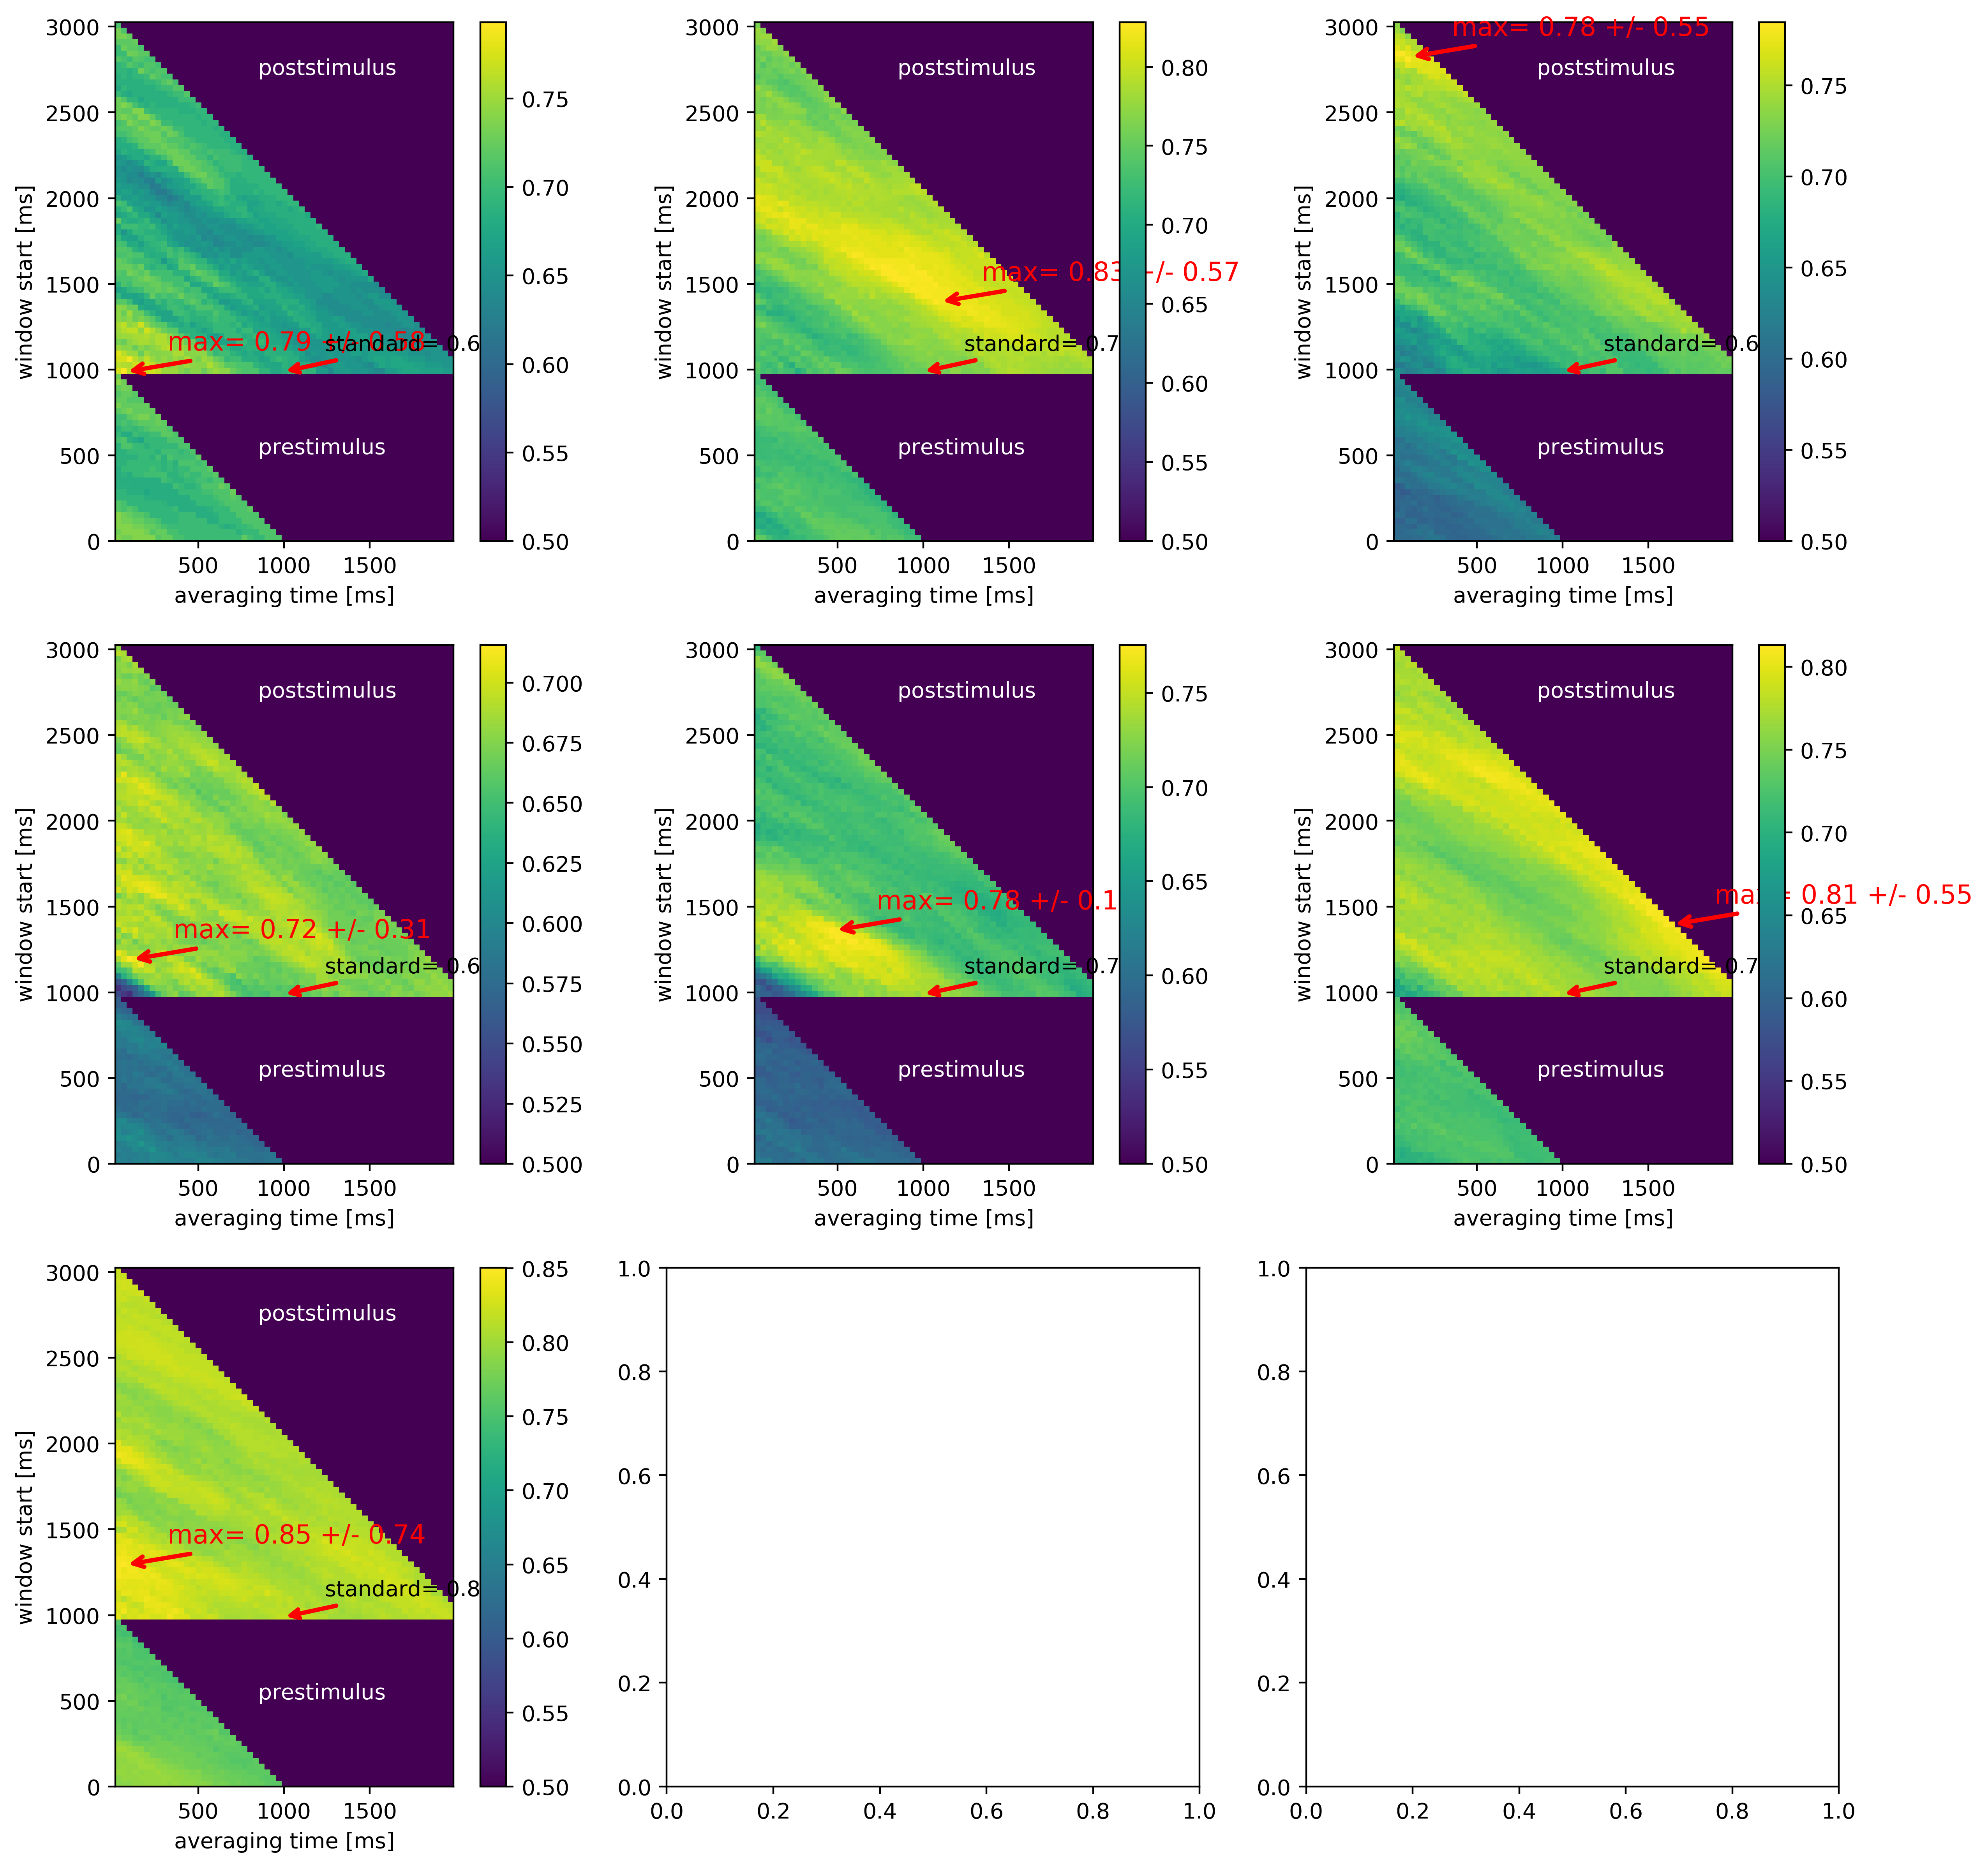

In [143]:
stim_ind = 1

n_stims = 7
tm = 'ms'
if tm == 'ms':
    fac = 17
else:
    fac = 1

m_scs = summed

m_scs_rectified = m_scs

for i in range(m_scs.shape[1]):
    for j in range(m_scs.shape[2]):
        if i < 29 and i > 29 - (j + 1):
            m_scs_rectified[:, i, j] = np.zeros(n_stims)
            
#m_scs_rectified[m_scs_rectified == 0] = 0.6

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3,  figsize=(15,15), dpi=400)
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

for stim_ind, ax in enumerate(axes):

    coords = np.where(m_scs_rectified[stim_ind, :,:] == m_scs_rectified[stim_ind, :,:].max())
    #ax.figure(figsize=(10,10))

    vmin = np.min(m_scs_rectified[m_scs_rectified != 0])
    im = ax.imshow(m_scs_rectified[stim_ind,:,:], origin='lower', interpolation='none', extent=[1*fac,117*fac, 0*fac, 178*fac], vmin=0.5)
    #cmap.set_under(color='gray')
    
    fig.colorbar(im, ax=ax)

    #plt.imshow(m_scs_rectified[stim_ind,:,:], origin='lower', interpolation='none', extent=[1,117, 0, 178])
    
    ax.text(50*fac, 30*fac, 'prestimulus', color='white')
    ax.text(50*fac, 160*fac, 'poststimulus', color='white')
    
    ax.annotate('max={0: .2f} +/-{1: .2f}'.format(m_scs[stim_ind,:,:].max(), 2*stds[coords[0][0],coords[1][0],stim_ind]), fontsize=12, xy=((coords[1][0]+1)*2*fac, (coords[0][0])*2*fac),
                xycoords='data', xytext=(20, 10),
                textcoords='offset points', color='red',
                arrowprops=dict(arrowstyle="->",
                                linewidth = 2.,
                                color = 'red'))
    ax.annotate('standard={0: .2f}'.format(m_scs[stim_ind, 29,29]), fontsize=10, xy=(58*fac, 58*fac),
                xycoords='data', xytext=(20, 10),
                textcoords='offset points',
                arrowprops=dict(arrowstyle="->",
                                linewidth = 2.,
                                color = 'red'))

    if tm=='ms':
        ax.set_ylabel('window start [ms]')
        ax.set_xlabel('averaging time [ms]')
    else:
        ax.set_ylabel('window start [frames]')
        ax.set_xlabel('averaging time [frames]')

In [3]:
def SVM_presence_combined_window(filename, start, stop, base='frac', svm_kernel='linear', cv=4):
    '''
    Trains an SVM on the Ca2+ data of all dendrites to detect/predict hits/misses.
    
    filename: string, name of experiment file
    start: int, starting frame of averaging window
    stop: int, final frame of averaging window
    base: string, mode of subtracting baseline.
        'normal': always subtract full baseline
        'frac': subtract baseline proportional to fraction of post-stiumulus frames
    svm_kernel: string, specifies svm kernel to use for training
    cv: int, number of folds for cv
    
    returns: n_stims x cv ndarray. Each row holds the accuracy values for each fold for one stimulus strength.
    '''
    assert(stop > start), "window needs to have positive size."
    assert(start >= 0), "start needs to be larger or equal to zero."
    
    f = h5py.File(filename+".hdf5", "r")
    data = smoothen(filename)
    #data = f['data']
    meta = f['meta']
    g = h5py.File(filename[:-6]+"roi.hdf5", "r")
    motion_mask = (g['inFrameDend'][:].astype(bool)).reshape(g['inFrameDend'].shape[0])
    stims = np.unique(f['meta'][:,1])
    #load data and stims
    
    assert(stop <= data.shape[2]), "Stop has to be smaller or equal to the number of frames"
    
    sc = np.zeros((stims.shape[0], cv))
    #will hold scores
    
    for k, amp in enumerate(stims):
        baseline = np.mean(data[:,motion_mask,:58], axis=2).reshape(data.shape[0], data[:,motion_mask,:].shape[1], 1)
        #baselibe for every trial is the mean over the first second - 58 frames
        
        #for 'frac' mode, make the weighting of the baseline proportional the the fraction of post stimulus frames
        if base == 'normal':
            bl_factor = 1
        if base == 'frac':
            n_pre = 58 - start
            n_post = stop - 58
            
            bl_factor = n_post/(n_pre + n_post)
            #compute baseline weight
            
            if n_pre <= 0:
                #start >= 58 -> everything is post stimulus
                bl_factor = 1
            if n_post <= 0:
                #stop <= 50 -> everything is pre-stimulus
                bl_factor = 0
        
        mn_dnd_chng = np.mean(data[:,motion_mask,start:stop]-baseline*bl_factor, axis=2)
        #mean dendritic change = second second minus baseline, mean

        present_mask = meta[:,1]==amp
        absent_mask = meta[:,1]==0
        #masks for present and absent trials

        trials_mask = np.logical_or(present_mask, absent_mask)
        #combine these to mask of all trials with stimulus zero or the chosen stimulus

        y_score = mn_dnd_chng[trials_mask, :]
        #scores used are mean dendritic changes in chosen trials

        amp_mask = meta[:,1][trials_mask]==amp
        y_true = (amp_mask-0.5)*2
        #stimulus present trials are marked as '1', absent ones as '-1'

        clf = svm.SVC(kernel=svm_kernel, class_weight='balanced')
        try:
            scores = cross_val_score(clf, y_score, y_true.reshape(y_true.shape[0]), cv=cv)
        except ValueError:
            scores = np.zeros(cv)
        sc[k,:] = scores
        #classifier and scores. If not enough instances of either class, return all zeros and continue loop.
        
    return sc

In [4]:
scss = []
for filename in filelist:
    f = h5py.File(filename+".hdf5", "r")

    n_stims = np.unique(f['meta'][:,1]).shape[0]
    cv = 4

    starts = np.arange(0, f['data'].shape[2], 2)
    av_times = np.arange(0, 118, 2) + 1

    scs = np.zeros((starts.shape[0], av_times.shape[0], n_stims, cv))
    for i, start in enumerate(starts):
        print('Computing iteration {} out of {}.'.format(i+1, starts.shape[0]))
        for j, av_time in enumerate(av_times):
            stop = start + av_time
            try:
                sc = SVM_presence_combined_window(filename, start, stop, cv=cv)
                scs[i, j, :, :] = sc
            except:
                scs[i, j, :, :] = np.zeros((n_stims, cv))
    scss.append(scs)

Computing iteration 1 out of 90.
Computing iteration 2 out of 90.
Computing iteration 3 out of 90.
Computing iteration 4 out of 90.
Computing iteration 5 out of 90.
Computing iteration 6 out of 90.
Computing iteration 7 out of 90.
Computing iteration 8 out of 90.
Computing iteration 9 out of 90.
Computing iteration 10 out of 90.
Computing iteration 11 out of 90.
Computing iteration 12 out of 90.
Computing iteration 13 out of 90.
Computing iteration 14 out of 90.
Computing iteration 15 out of 90.
Computing iteration 16 out of 90.
Computing iteration 17 out of 90.
Computing iteration 18 out of 90.
Computing iteration 19 out of 90.
Computing iteration 20 out of 90.
Computing iteration 21 out of 90.
Computing iteration 22 out of 90.
Computing iteration 23 out of 90.
Computing iteration 24 out of 90.
Computing iteration 25 out of 90.
Computing iteration 26 out of 90.
Computing iteration 27 out of 90.
Computing iteration 28 out of 90.
Computing iteration 29 out of 90.
Computing iteration 30 

In [5]:
f = h5py.File('window_scores_presence', 'w-')
for i, filename in enumerate(filelist):
    f[filename] = scss[i]
f.close()

In [18]:
f = h5py.File('window_scores_presence', 'r')

summed = np.zeros((7, f[filelist[0]].shape[0], f[filelist[0]].shape[1]))

for i in range(7):
    for filename in filelist:
        m_scs = np.mean(f[filename], axis=3)
        summed[i] += m_scs[:,:,i]
            
for i in range(7):
    summed[i] = summed[i]/len(filelist)
    
f.close()

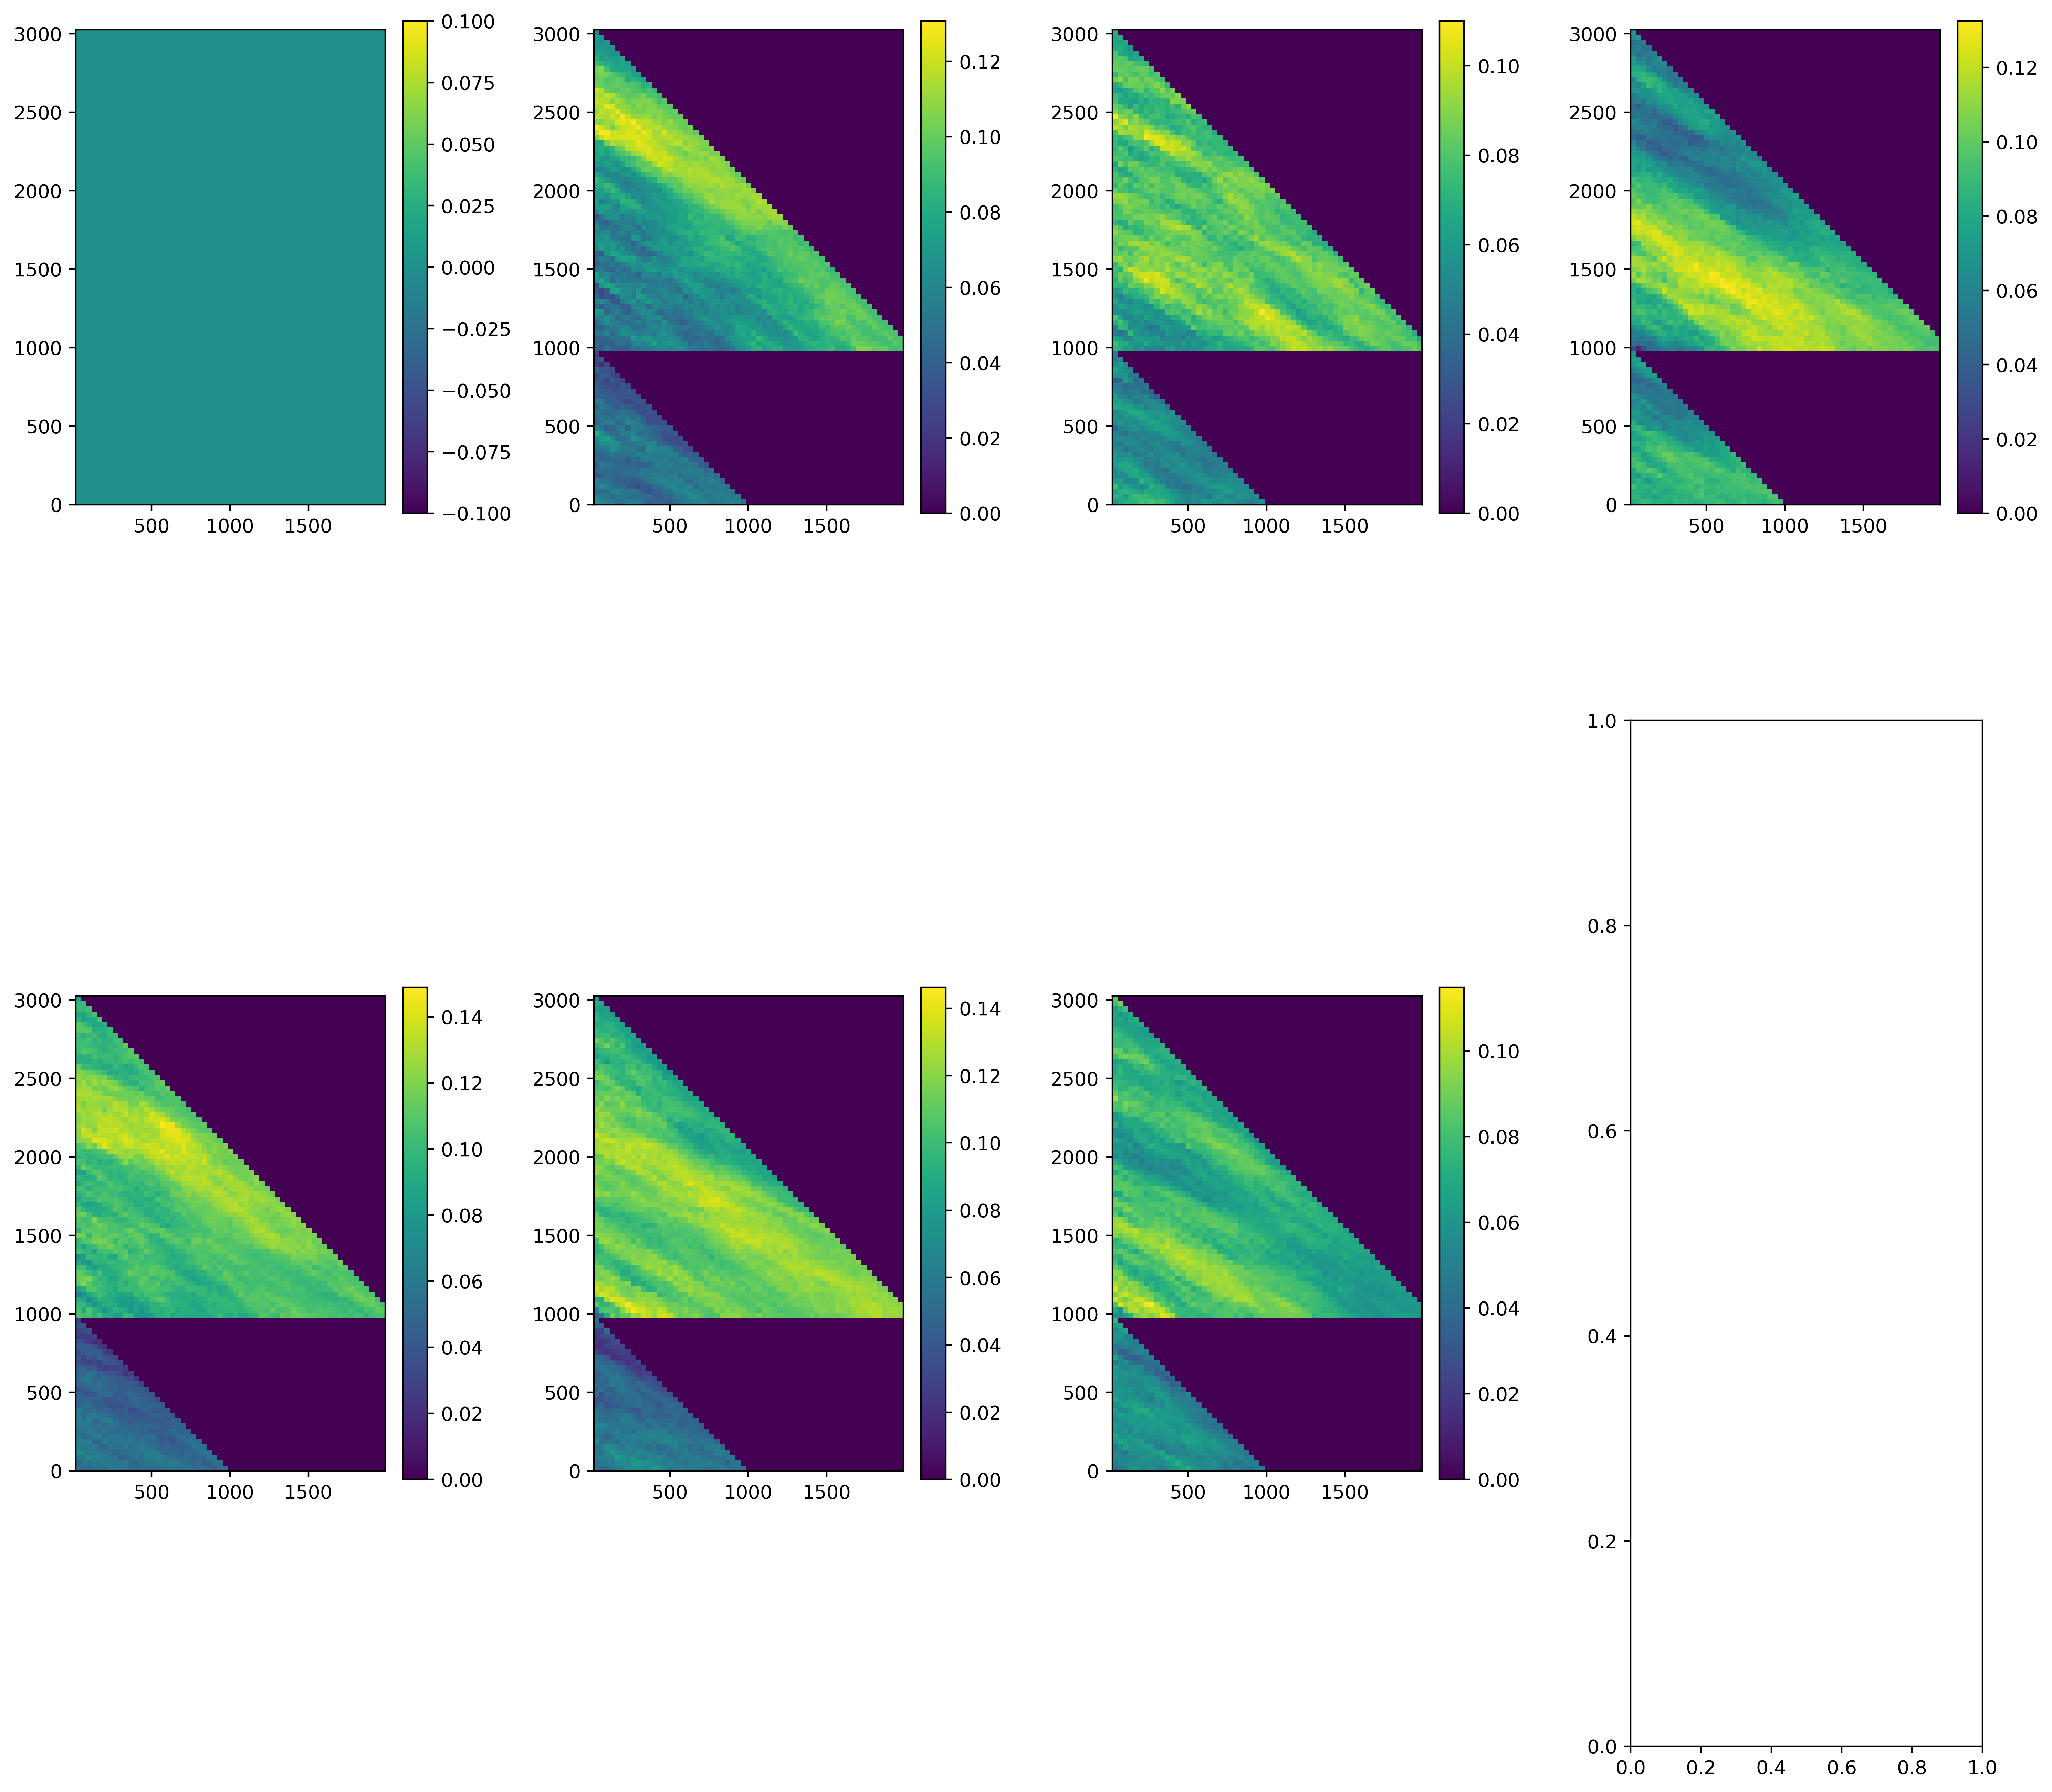

In [69]:
f = h5py.File('window_scores_presence', 'r')
mns=[]
for a in range(8):
    mn = np.mean(f[filelist[a]], axis=3)
    for i in range(mn.shape[0]):
        for j in range(mn.shape[1]):
            if i < 29 and i > 29 - (j + 1):
                mn[i, j, :] = np.zeros(7)
    mns.append(mn)
mns = np.array(mns)
stds = np.std(mns, axis=0)

vmin = np.min(stds.flatten())
vmax = np.max(stds.flatten())

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(15,15), dpi=400)
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

for i, ax in enumerate(axes):
    im = ax.imshow(stds[:,:,i], origin='lower', extent=[1*fac,117*fac, 0*fac, 178*fac])#, vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=ax, fraction=0.07)
    
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=axc1)
#fig.colorbar(im, cax=axc2)
plt.tight_layout()
f.close()

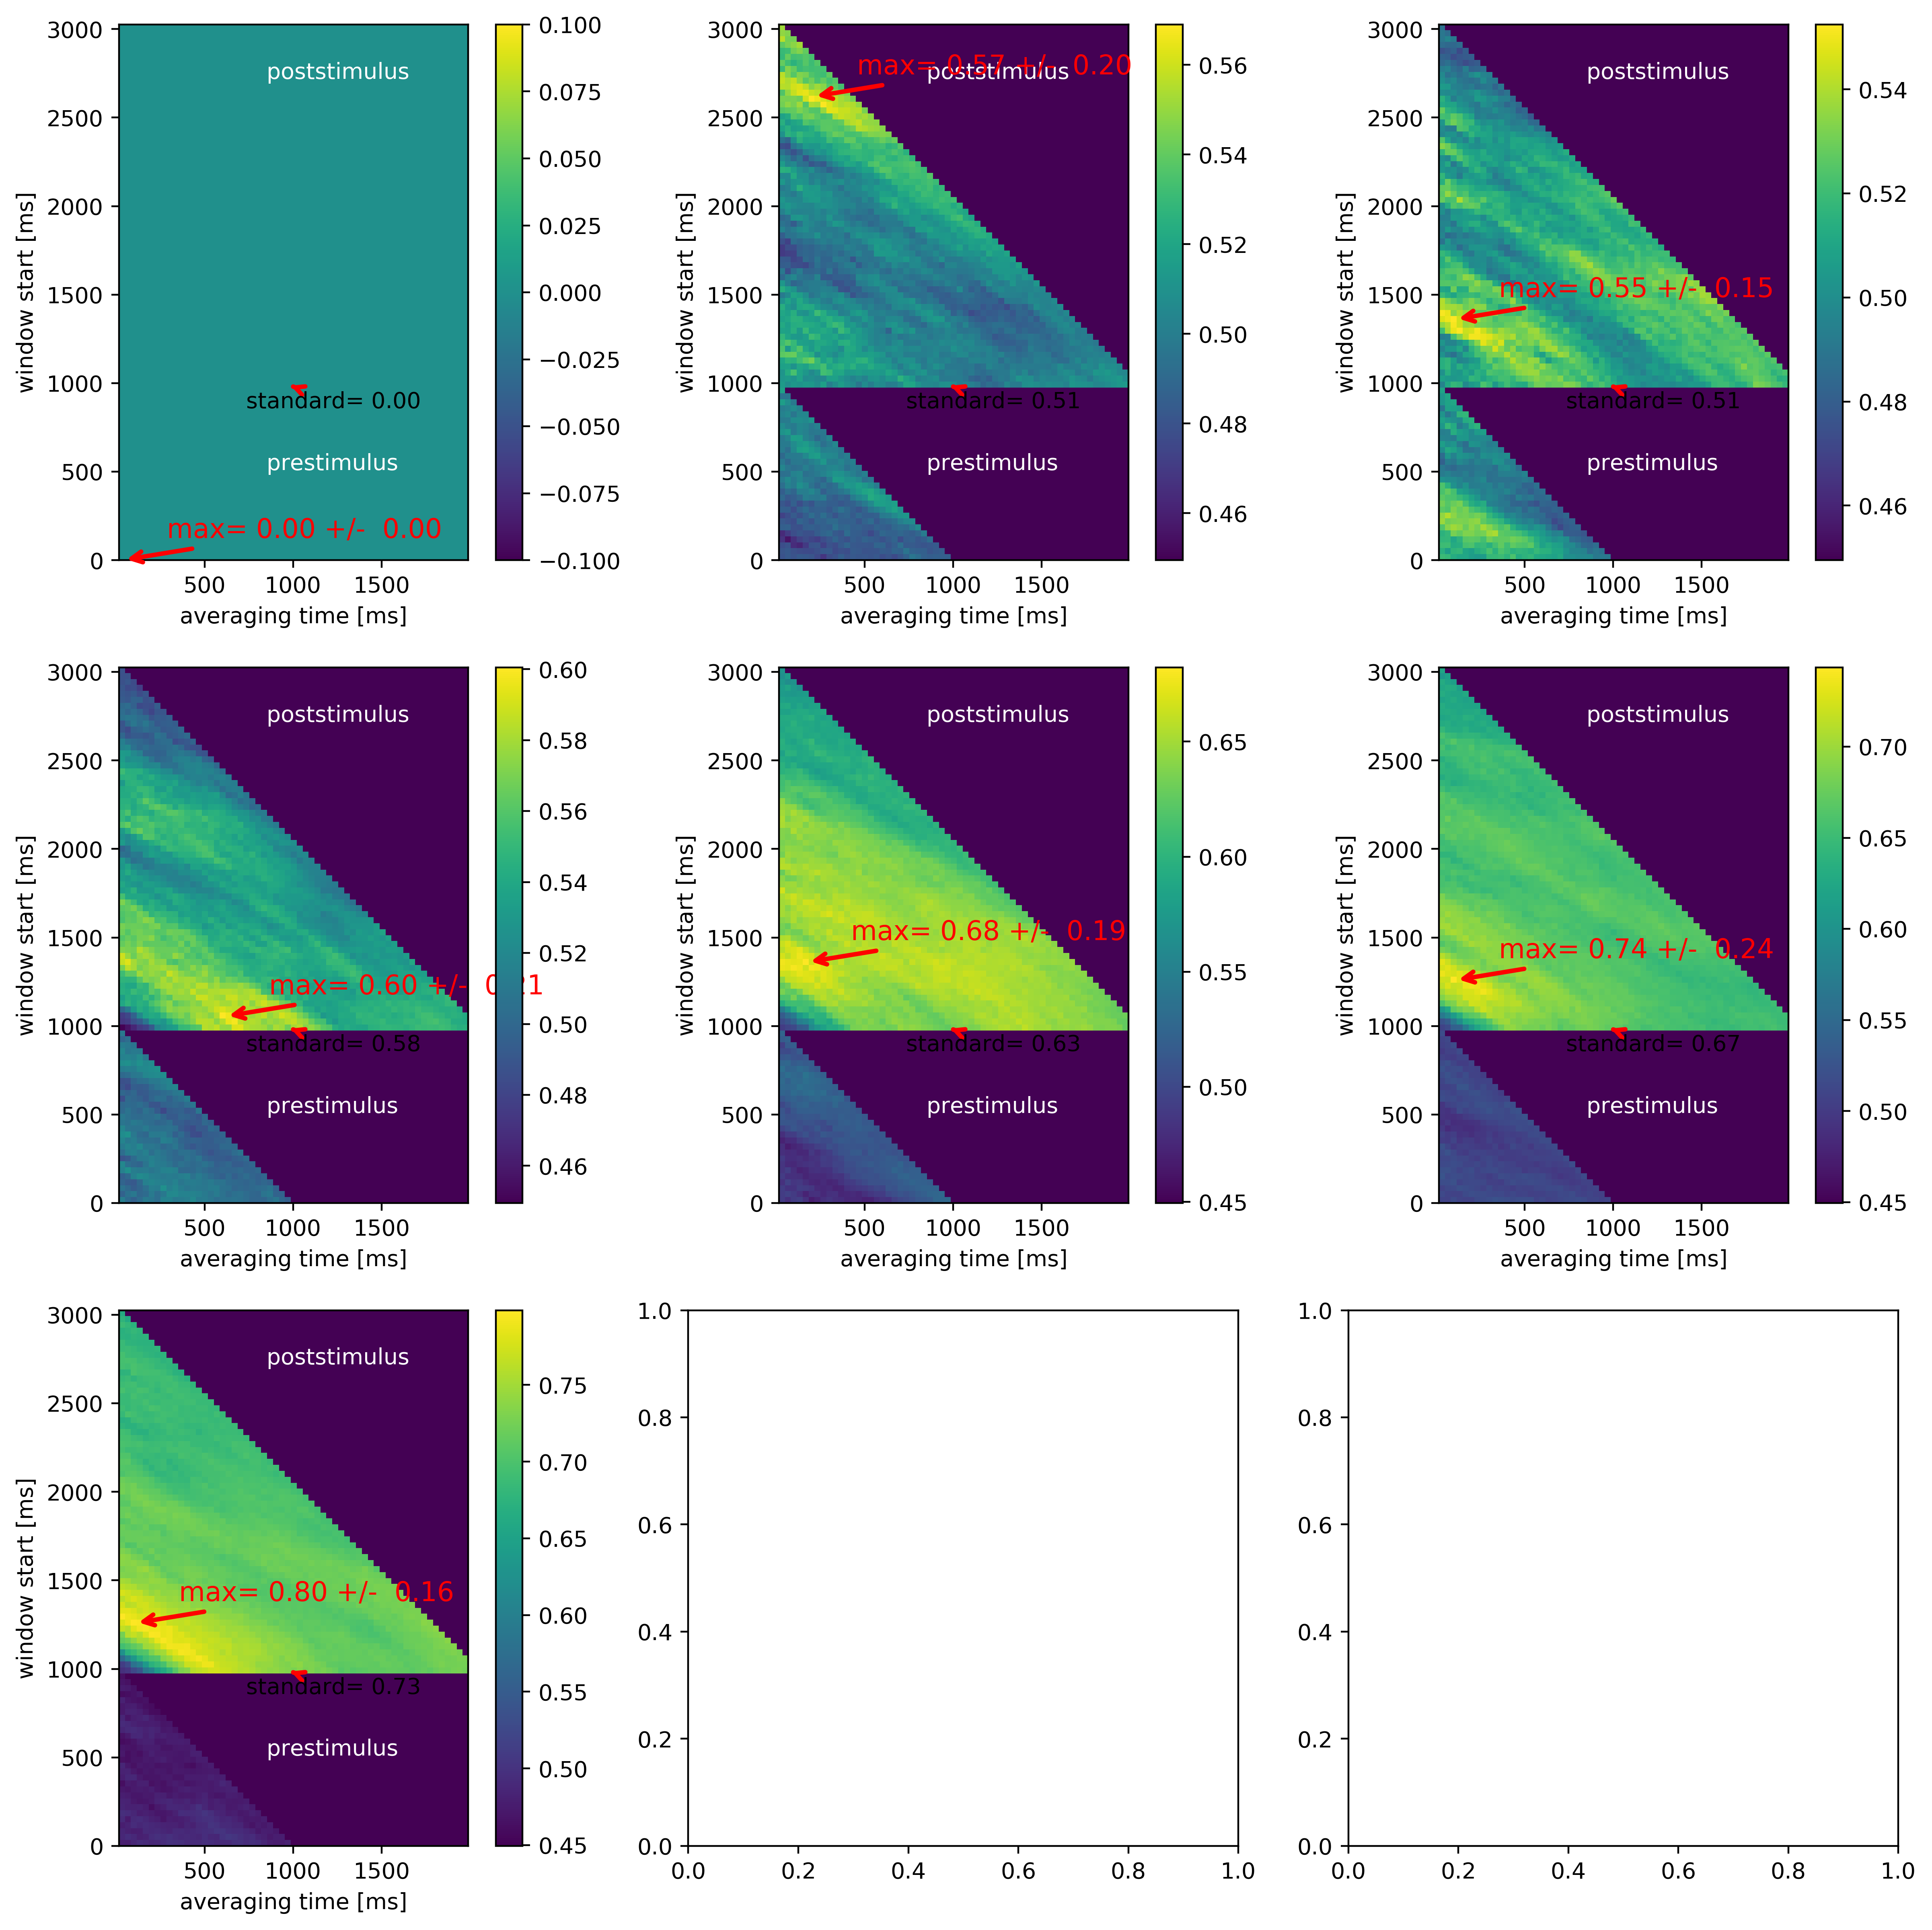

In [72]:
stim_ind = 1

n_stims = 7
tm = 'ms'
if tm == 'ms':
    fac = 17
else:
    fac = 1

m_scs = summed

m_scs_rectified = m_scs

for i in range(m_scs.shape[1]):
    for j in range(m_scs.shape[2]):
        if i < 29 and i > 29 - (j + 1):
            m_scs_rectified[:, i, j] = np.zeros(n_stims)
            
#m_scs_rectified[m_scs_rectified == 0] = 0.6

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(15,15), dpi=400)
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

for stim_ind, ax in enumerate(axes):

    coords = np.where(m_scs_rectified[stim_ind, :,:] == m_scs_rectified[stim_ind, :,:].max())
    #ax.figure(figsize=(10,10))
    
    if stim_ind != 0:
        vmin = np.min(m_scs_rectified[m_scs_rectified != 0])
    else:
        vmin=None
    im = ax.imshow(m_scs_rectified[stim_ind,:,:], origin='lower', interpolation='none', extent=[1*fac,117*fac, 0*fac, 178*fac], vmin=vmin)
    #cmap.set_under(color='gray')

    #plt.imshow(m_scs_rectified[stim_ind,:,:], origin='lower', interpolation='none', extent=[1,117, 0, 178])
    
    fig.colorbar(im, ax=ax)
    
    ax.text(50*fac, 30*fac, 'prestimulus', color='white')
    ax.text(50*fac, 160*fac, 'poststimulus', color='white')
    
    ax.annotate('max={0: .2f} +/- {1: .2f}'.format(m_scs[stim_ind,:,:].max(), 2*stds[coords[0][0],coords[1][0],stim_ind]), fontsize=12, xy=((coords[1][0]+1)*2*fac, (coords[0][0])*2*fac),
                xycoords='data', xytext=(20, 10),
                textcoords='offset points', color='red',
                arrowprops=dict(arrowstyle="->",
                                linewidth = 2.,
                                color = 'red'))
    ax.annotate('standard={0: .2f}'.format(m_scs[stim_ind, 29,29]), fontsize=10, xy=(58*fac, 58*fac),
                xycoords='data', xytext=(-20, -10),
                textcoords='offset points',
                arrowprops=dict(arrowstyle="->",
                                linewidth = 2.,
                                color = 'red'))

    if tm=='ms':
        ax.set_ylabel('window start [ms]')
        ax.set_xlabel('averaging time [ms]')
    else:
        ax.set_ylabel('window start [frames]')
        ax.set_xlabel('averaging time [frames]')
    

In [102]:
f = h5py.File('clfs_presence', 'w')
g = h5py.File('clfs_hitmiss', 'w')

filedict = {}
errcount = 0
for k, filename in enumerate(filelist):
    h = h5py.File(filename+'.hdf5', 'r')
    try:
        clfs_presence = SVM_presence_combined_clf(filename)
        clfs_hitmiss = SVM_hitmiss_combined_clf(filename)[0]
        filedict[k] = k-errcount
    except ValueError:
        errcount += 1
        continue
    
    l = h5py.File(filename[:-6]+"roi.hdf5", "r")
    motion_mask = (l['inFrameDend'][:].astype(bool)).reshape(l['inFrameDend'].shape[0])
    n_dend = np.sum(motion_mask)
    
    coefs_presence = np.zeros((len(clfs_presence), n_dend))
    coefs_hitmiss = np.zeros((len(clfs_hitmiss), n_dend))
    intercept_presence = np.zeros(len(clfs_presence))
    intercept_hitmiss = np.zeros(len(clfs_hitmiss))
    for i in range(len(clfs_presence)):
        coefs_presence[i] = clfs_presence[i].coef_[0]
        coefs_hitmiss[i] = clfs_hitmiss[i].coef_[0]
        intercept_presence[i] = clfs_presence[i].intercept_[0]
        intercept_hitmiss[i] = clfs_hitmiss[i].intercept_[0]
    f[filename+'_coefs'] = coefs_presence
    g[filename+'_coefs'] = coefs_hitmiss
    f[filename+'_intercept'] = intercept_presence
    g[filename+'_intercept'] = intercept_hitmiss

f.close()
g.close()

with open('filedict.json', 'w') as h:
    json.dump(filedict, h)

In [163]:
j = 1
w_presence = clfs_presence[j].coef_[0]

In [164]:
a = -w_presence[0] / w_presence[1]
xx = np.linspace(-5, 5)
yy = a * xx - (clfs_presence[j].intercept_[0]) / w_presence[1]

    # plot the parallels to the separating hyperplane that pass through the
    # support vectors
margin = 1 / np.sqrt(np.sum(clfs_presence[j].coef_ ** 2))
yy_down = yy + a * margin
yy_up = yy - a * margin

In [176]:
clfs_presence[j].intercept_

array([-0.33743694])